# Classificação de clientes inadimplentes


### 1. Introdução

EDA + Clusterização + Classificação

Olá meus futuros colegas da STONE, neste arquivo nós exploraremos o dataset "case_credit_data_science" que contém um conjunto de informações sobre clientes da famosa e renomada instituição bancária "Spock Bank".

#### Formulação do problema
**Sobre a empresa**  
A Spock Bank lida com concessão de crédito para novos e antigos clientes

**Problema**  
A empresa quer prever a probabilidade de um cliente ser inadimplente ou não de acordo com o perfil do mesmo.

_Descrição do Dataset:_

* client_id : Identificar único
* pf_ou_pj : Pessoa física ou jurídica?
* grade : Categoria de risco
* sub_grade : Subcategoria de risco
* qtd_restritivos :  Quantidade de restritivos que o cliente possui
* verificacao_fonte_de_renda : Fonte de renda foi verificada?
* razao_credito_tomado_vs_renda_informada : Razão ente o valor de crédito tomado pelo cliente e sua renda informada
* patrimonio_total: Valor total do patrimônio financeiro
* contas_distintas_com_atraso : Quantidade de contas bancárias distintas que o cliente possui, com pelo menos 1 atraso
* qtd_consultas_ultimos_6m : Quantidade de vezes que o documento do cliente foi consultado em bureaus, nos últimos 6 meses
* qtd_linhas_credito_abertas: Quantidade de linhas de crédito abertas para o cliente na instituição financeira
* saldo_rotativo_total : Saldo rotativo total
* limite_rotativo_total: Limite rotativo total
* valor total emprestimos tomados: Valor total dos empréstimos tomados pelo cliente
* taxa_juros_media_emprestimos_tomados: Taxa de juros média dos empréstimos tomados pelo cliente
* target: 0 = não inadimplente, 1 = inadimplente

### 2. Bibliotecas

In [546]:
import pandas as pd
import numpy as np
import math

import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, make_scorer , roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import  roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import set_config

import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency, randint, uniform, f_oneway

import joblib



### 3. Explorando os dados

In [394]:
# Carregando o dataset
credito_df = pd.read_csv("C:\\Users\\erika\\OneDrive\\Documentos\\Stone\\Arquivos_Case_Tecnico_Credit_Data_Science-20250408T173929Z-001\\Arquivos_Case_Tecnico_Credit_Data_Science\\case_data_science_credit.csv", sep = ";")

# Mostrando as primeiras linhas
pd.set_option('display.max_columns', None)
credito_df.head()

client_id pf_ou_pj grade sub_grade  qtd_restritivos  \
0      75521       PF     B        C4                0   
1      28124       PF     C        D3                0   
2       8420       PF     F        D4                0   
3      22553       PF     C        C3                0   
4      62952       PF     C        D4                1   

  verificacao_fonte_de_renda  razao_credito_tomado_vs_renda_informada  \
0               Not Verified                                16.284758   
1            Source Verified                                15.412409   
2            Source Verified                                28.137619   
3            Source Verified                                18.043730   
4            Source Verified                                17.209886   

   patrimonio_total  qtd_atrasos_ultimos_2a  \
0      176346.62670                       1   
1       39833.92100                       0   
2       91506.69105                       0   
3      108286.57590                       1   
4       44234.82545                       1   

   valor_total_recuperacoes_ultimos_2a  contas_distintas_com_atraso  \
0                             2.498291                            0   
1                             2.377215                            0   
2                             4.316277                            0   
3                             0.107020                            0   
4                          1294.818751                            0   

   qtd_consultas_ultimos_6m  qtd_linhas_credito_abertas  saldo_rotativo_total  \
0                         0                          13                 24246   
1                         0                          12                   812   
2                         0                          14                  1843   
3                         0                           7                 13819   
4                         3                          13                  1544   

   limite_rotativo_total  valor_total_emprestimos_tomados  \
0                   6619                            10000   
1                  20885                             3609   
2                  26155                            28276   
3                  60214                            11170   
4                  22579                            16890   

   taxa_juros_media_emprestimos_tomados  target  
0                             11.135007       0  
1                             12.237563       0  
2                             12.545884       0  
3                             16.731201       0  
4                             15.008300       0

In [243]:
# Verificando se possui valores faltantes e o tipo das variáveis
credito_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   client_id                                67463 non-null  int64  
 1   pf_ou_pj                                 67463 non-null  object 
 2   grade                                    67463 non-null  object 
 3   sub_grade                                67463 non-null  object 
 4   qtd_restritivos                          67463 non-null  int64  
 5   verificacao_fonte_de_renda               67463 non-null  object 
 6   razao_credito_tomado_vs_renda_informada  67463 non-null  float64
 7   patrimonio_total                         67463 non-null  float64
 8   qtd_atrasos_ultimos_2a                   67463 non-null  int64  
 9   valor_total_recuperacoes_ultimos_2a      67463 non-null  float64
 10  contas_distintas_com_atraso              67463

Vemos que o dataset possui 67463 observações e que não temos valores faltantes em nenhuma das variáveis. Além disso, o tipo das variáveis estão de acordo com o esperado.

In [395]:
# Verificando se há duplicidade
credito_df.duplicated().sum()

np.int64(0)

Não precisamos nos preocupar com valores em duplicidade também. Agora vamos entender melhor como estão distribuídos

#### 3.1 Análise univariada

In [396]:
# Identificando colunas categóricas e numéricas
dist_cat_cols = ['pf_ou_pj', 'grade', 'sub_grade', 'verificacao_fonte_de_renda']

dist_num_cols = [col for col in credito_df.columns if col not in dist_cat_cols + ['client_id']]

In [397]:
# Dimensões da grade
n = len(dist_cat_cols)
ncols = 2
nrows = math.ceil(n/ncols)

# Criando a grade de subplots 
fig = make_subplots(rows = nrows, cols = ncols, subplot_titles= dist_cat_cols)

# Adicionando plots
for i, col in enumerate(dist_cat_cols):
    df = credito_df.groupby([col], as_index = False).agg(Quantidade = ('client_id', 'count'))
    row = i // ncols + 1
    col_pos = i % ncols +1
    fig.add_trace(
        go.Bar(x = df[col], y = df['Quantidade'], text = df['Quantidade'], textposition= 'auto'),
                   row = row, col = col_pos)
    
# Layout final
fig.update_layout(title = 'Distribuição de variáveis categóricas', showlegend = False)

fig.show()


Nossos dados são predominantemente de Pessoas física, sendo que aproximadamente 50% dos clientes teve verificação de fonte de renda do tipo 'Source Verified'

In [398]:
# Dimensões da grade
n = len(dist_num_cols)
ncols = 3
nrows = math.ceil(n/ncols)

# Criando a grade de subplots 
fig = make_subplots(rows = nrows, cols = ncols, subplot_titles= dist_num_cols)

# Adicionando plots
for i, col in enumerate(dist_num_cols):
    row = i // ncols + 1
    col_pos = i % ncols +1
    fig.add_trace(
        go.Histogram(x = credito_df[col], name = col),
                   row = row, col = col_pos)
    
# Layout final
fig.update_layout(title = 'Distribuição de variáveis numéricas', showlegend = False, 
                  height = 300*nrows)

fig.show()

Os plots acima nos fazem perceber o seguinte:
- Cerca de 14,18% dos clientes analizados ficaram inadimplentes em algum momento
- Nenhuma das pessoas possui contas distintas com atrazo (então a variável 'contas_distintas_com_atrazo' não precisa entrar no modelo)



#### 3.2 Análise bivariada

In [404]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Suponha que você tenha 4 colunas categóricas
dist_cat_cols = ['verificacao_fonte_de_renda', 'pf_ou_pj', 'grade', 'sub_grade']

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=dist_cat_cols,
    vertical_spacing=0.2,
    horizontal_spacing=0.2
)

positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

for i, col in enumerate(dist_cat_cols):
    row, col_pos = positions[i]
    
    # Agrupando e organizando os dados
    data = (
        credito_df
        .groupby([col, 'target'], as_index=False)
        .agg(count=('client_id', 'count'))
    )

    # Itera pelos valores únicos de 'target'
    for target_val in sorted(data['target'].unique()):
        filtered = data[data['target'] == target_val]
        
        fig.add_trace(
            go.Bar(
                x=filtered[col],
                y=filtered['count'],
                name=f"target={target_val}",
                showlegend=(i == 0)  # mostra legenda apenas na 1ª subplot
            ),
            row=row,
            col=col_pos
        )

# Layout
fig.update_layout(
    height=800,
    width=None,
    autosize = True,
    title_text='Distribuição das variáveis categóricas por target',
    barmode='group'
)

fig.show()


In [249]:
pf_pj = credito_df.groupby(['pf_ou_pj', 'target'], as_index  = False).agg(Quantidade = ('client_id', 'count'))
pf_pj_total = pf_pj.groupby(['pf_ou_pj'], as_index = False).agg(Total = ('Quantidade', 'sum'))
pf_pj2 = pf_pj.merge(pf_pj_total, how = 'left', on = 'pf_ou_pj')
pf_pj2['perc_target'] = round(100*pf_pj2['Quantidade']/pf_pj2['Total'], 2)
pf_pj2

pf_ou_pj  target  Quantidade  Total  perc_target
0       PF       0       57789  67340        85.82
1       PF       1        9551  67340        14.18
2       PJ       0         105    123        85.37
3       PJ       1          18    123        14.63

Apesar de a quantidade absoluta de pessoas físicas ser maior no dataset — o que resulta em um número maior de inadimplentes nesse grupo —, ao analisarmos proporcionalmente, observamos que os dois tipos de clientes (pessoa física e jurídica) apresentam taxas de inadimplência bastante semelhantes. Isso indica que o tipo de cliente, por si só, não parece ser um fator determinante para inadimplência nesse conjunto de dados.

       qtd_restritivos  razao_credito_tomado_vs_renda_informada  \
count     67463.000000                             67463.000000   
mean          0.081437                                23.299241   
std           0.346606                                 8.451824   
min           0.000000                                 0.675299   
25%           0.000000                                16.756416   
50%           0.000000                                22.656658   
75%           0.000000                                30.048400   
max           4.000000                                39.629862   

       patrimonio_total  qtd_atrasos_ultimos_2a  \
count      67463.000000            67463.000000   
mean       80541.502522                0.327127   
std        45029.120366                0.800888   
min        14573.537170                0.000000   
25%        51689.843335                0.000000   
50%        69335.832680                0.000000   
75%        94623.322785                

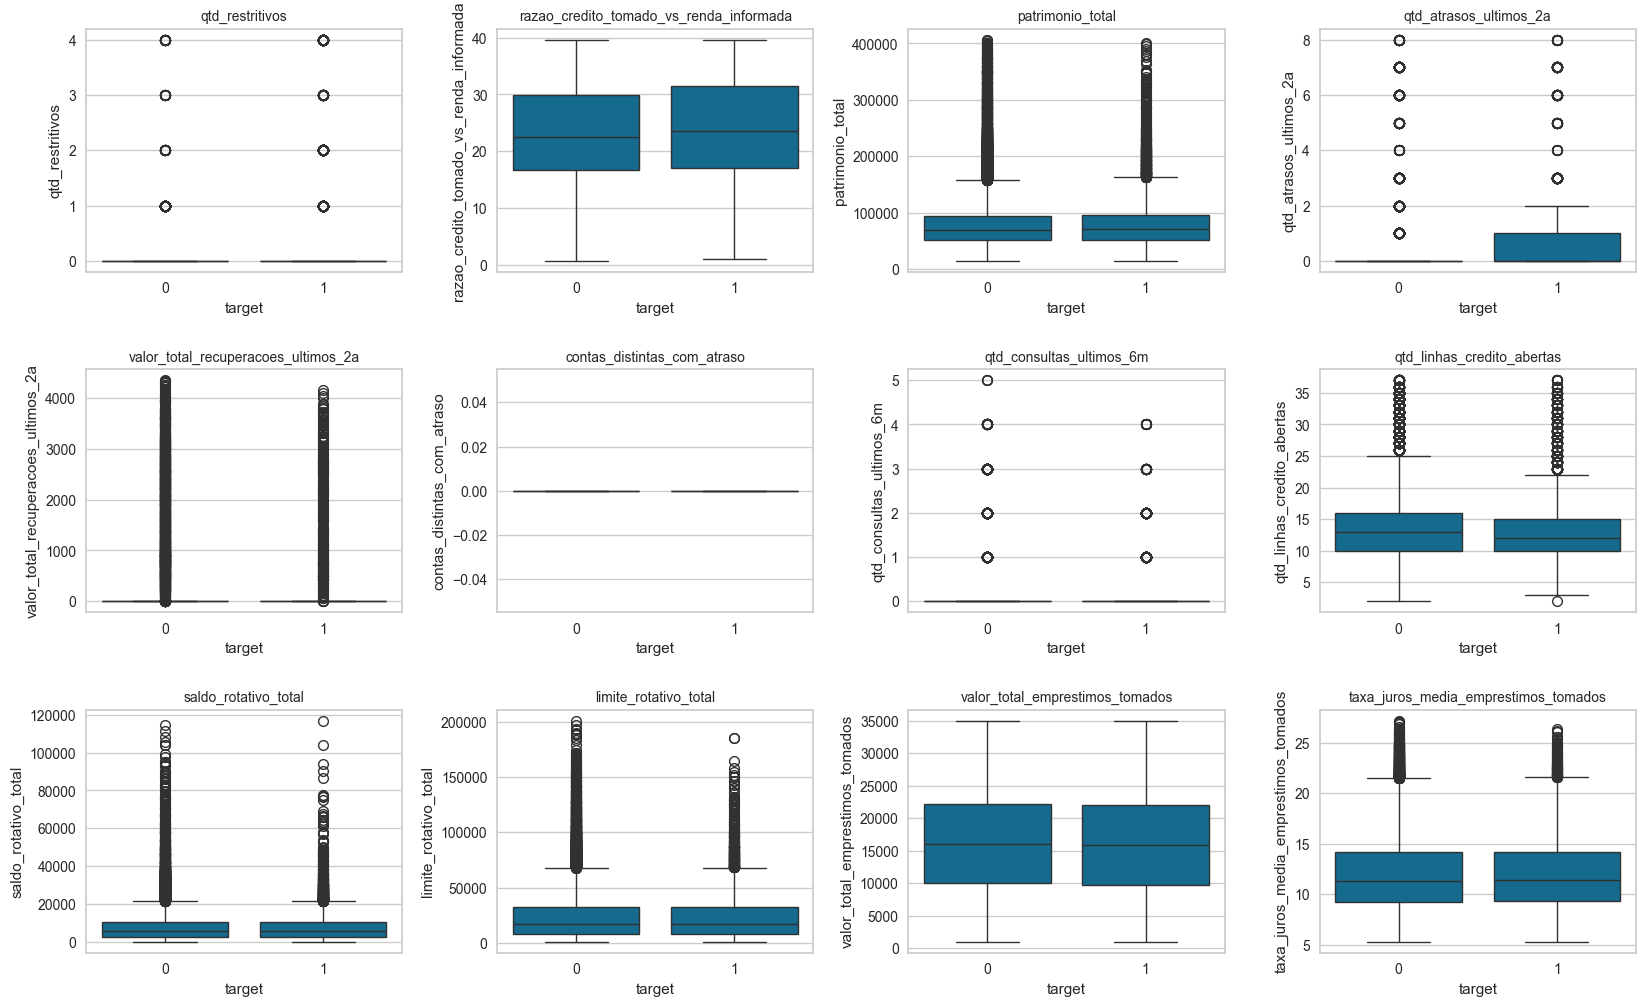

In [250]:
dist_num_cols_sem_target = [var for var in dist_num_cols if var != 'target']
n = len(dist_num_cols_sem_target)

# Criando grade de subplots
fig, axes = plt.subplots(3,4, figsize = (20,12))
axes = axes.flatten()

# Criando boxplots
for idx, num_cols in enumerate(dist_num_cols_sem_target):
    sns.boxplot(y = num_cols, data = credito_df, x = 'target', ax = axes[idx])
    axes[idx].set_title(f'{num_cols}', fontsize = 10)

# Removendo plots vazios caso sobrem eixos
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])


print(credito_df[dist_num_cols_sem_target].describe())
plt.subplots_adjust(hspace=0.4,wspace = 0.3)
plt.show()

In [ ]:
# # Retirando variáveis que não usaremos
# credito_df_sem_id = credito_df.drop(columns = ['client_id', 'contas_distintas_com_atraso'], axis = 1)
# dist_num_cols_sem_target2 = [var for var in dist_num_cols if var != 'contas_distintas_com_atraso']

In [405]:
# Colunas que podem ser retiradas da análise
colunas_para_deletar = ['client_id', 'contas_distintas_com_atraso']

### 4. Correlação dos dados

In [406]:
# Dados para correlação 
credito_para_corr = credito_df.copy()
credito_para_corr = credito_para_corr.drop(columns = colunas_para_deletar, axis = 1)

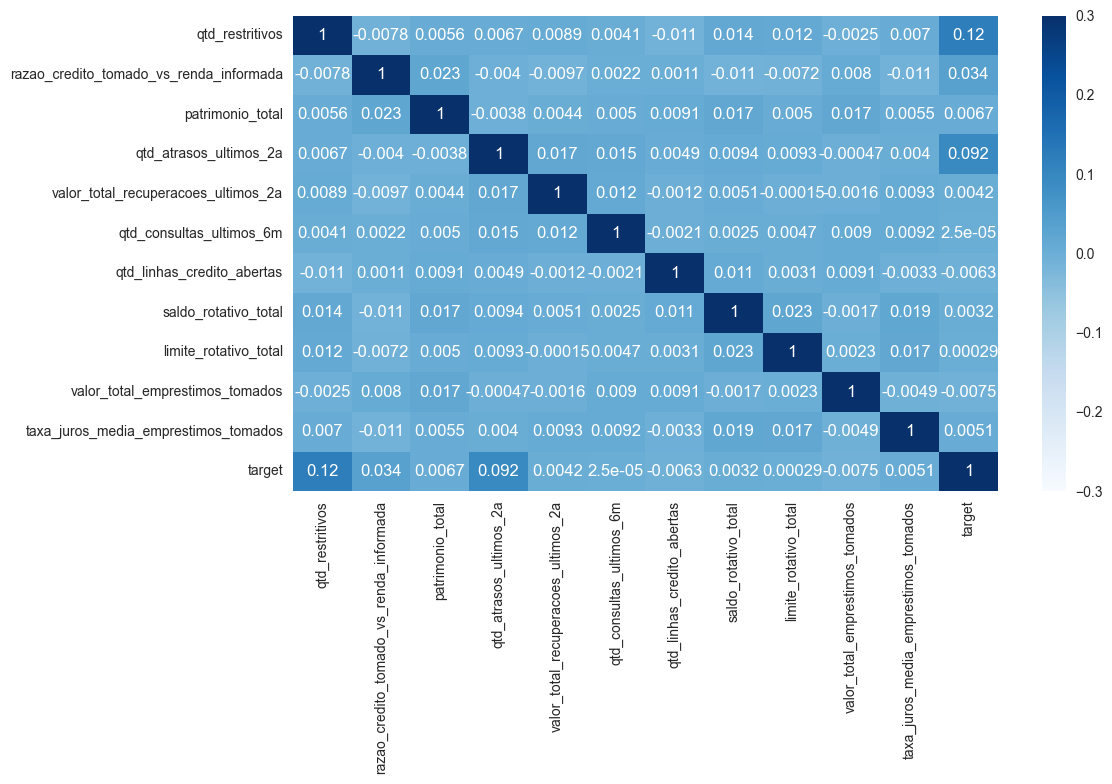

In [407]:
# Aplicando a matrix de correlação
corr_matrix = credito_para_corr.corr(numeric_only= True)


fig, ax = plt.subplots(figsize = (12,8))
sns.heatmap(corr_matrix, cmap = 'Blues', annot = True, ax=ax, vmax = 0.3, vmin = -0.3)

plt.tight_layout()
plt.show()

Através dessa matrix de correlação conseguimos ver que nenhuma das demais variáveis tem correlação forte com a variável target. Entendendo que correlação não significa causalidade, podemos identificar que há uma correlação positiva entre a quantidade de restritivos e a inadimplência, ou seja, a medida que a quantidade de restritivos aumenta, a probabilidade de inadimplência também aumenta. Da mesma forma para a quantidade de atrasos nos últimos 2 anos, a correlação, apesar de pequena, também se mostra positiva. Por outro lado vemos que o valor total de empréstimos tomados apresenta uma correlação negativa em relação a inadimplência, podemos interpretar isso sendo quanto maior a quantidade de empréstimos, menor a probabilidade de inadimplência. 

Mesmo identificando correlações muito fracas, vamos manter todas as variáveis no modelo e ver como o modelo se comporta. Dessa forma podemos fazer ajustes a medida que vamos avaliando os resultados.

### 5. Clusterização

In [408]:
credito_df_cluster = credito_para_corr.copy()


5.1 Categorial Feature Encoding

In [255]:
credito_df_cluster[dist_cat_cols].nunique()

pf_ou_pj                       2
grade                          7
sub_grade                     35
verificacao_fonte_de_renda     3
dtype: int64

Vemos que a variável 'pf_ou_pj' só possui dois valores, então podemos considerar uma variável binária (0 e 1). Já as variáveis 'grade' e 'sub_grade' possuem mais categorias e é importante notar que elas são consideradas variáveis ordenadas e seguem uma ordem crescente de risco, então alguém com uma grade A tem menor risco de inadimplência do que alguém com uma grade B. Enquanto para a variável 'verificacao_fonte_de_renda' podemos notar que é não binária e não ordenada, que será tratada pelo método one hot encoding.

In [409]:
# Definindo variáveis ordenadas
cat_cols_ord = ['grade', 'sub_grade']
# Definindo variável binária
cat_cols_bin = ['pf_ou_pj']
# Definindo variável one hot
cat_cols_one_hot = ['verificacao_fonte_de_renda']

In [410]:
# Criando encoders

# Definindo ranking e ordem 
grade_ordem = sorted(credito_df_cluster['grade'].dropna().unique())
sub_grade_ordem = sorted(credito_df_cluster['sub_grade'].dropna().unique())

# Definindo encoder ordinal
ord_encoder = OrdinalEncoder(categories= [grade_ordem, sub_grade_ordem])

# Definindo encoder binário
bin_encoder = OrdinalEncoder()

# Definindo one_hot encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [413]:
# Fit/tranform encoders 

# Ordinal
ord_encoded = ord_encoder.fit_transform(credito_df_cluster[cat_cols_ord])

# Binários
bin_encoded = bin_encoder.fit_transform(credito_df_cluster[cat_cols_bin])

# One-hot
one_hot_endoded = one_hot_encoder.fit_transform(credito_df_cluster[cat_cols_one_hot])

In [414]:
# Juntando todas as variávies categóricas após o encoding
cat_df_encoded = pd.DataFrame()

for data, colu_names in zip([ord_encoded, bin_encoded, one_hot_endoded],
                            [cat_cols_ord, cat_cols_bin, one_hot_encoder.get_feature_names_out()]):
    df = pd.DataFrame(data, index = credito_df_cluster.index)
    df.columns = colu_names

    cat_df_encoded = pd.concat([cat_df_encoded, df], axis = 1)

cat_df_encoded.head()

grade  sub_grade  pf_ou_pj  verificacao_fonte_de_renda_Not Verified  \
0    1.0       13.0       0.0                                      1.0   
1    2.0       17.0       0.0                                      0.0   
2    5.0       18.0       0.0                                      0.0   
3    2.0       12.0       0.0                                      0.0   
4    2.0       18.0       0.0                                      0.0   

   verificacao_fonte_de_renda_Source Verified  \
0                                         0.0   
1                                         1.0   
2                                         1.0   
3                                         1.0   
4                                         1.0   

   verificacao_fonte_de_renda_Verified  
0                                  0.0  
1                                  0.0  
2                                  0.0  
3                                  0.0  
4                                  0.0

In [415]:
col_not_cat = [var for var in dist_num_cols if var != 'contas_distintas_com_atraso']
credito_cluster_all = pd.concat([credito_df_cluster[col_not_cat], cat_df_encoded], axis = 1 )
credito_cluster_all.head()

qtd_restritivos  razao_credito_tomado_vs_renda_informada  patrimonio_total  \
0                0                                16.284758      176346.62670   
1                0                                15.412409       39833.92100   
2                0                                28.137619       91506.69105   
3                0                                18.043730      108286.57590   
4                1                                17.209886       44234.82545   

   qtd_atrasos_ultimos_2a  valor_total_recuperacoes_ultimos_2a  \
0                       1                             2.498291   
1                       0                             2.377215   
2                       0                             4.316277   
3                       1                             0.107020   
4                       1                          1294.818751   

   qtd_consultas_ultimos_6m  qtd_linhas_credito_abertas  saldo_rotativo_total  \
0                         0                          13                 24246   
1                         0                          12                   812   
2                         0                          14                  1843   
3                         0                           7                 13819   
4                         3                          13                  1544   

   limite_rotativo_total  valor_total_emprestimos_tomados  \
0                   6619                            10000   
1                  20885                             3609   
2                  26155                            28276   
3                  60214                            11170   
4                  22579                            16890   

   taxa_juros_media_emprestimos_tomados  target  grade  sub_grade  pf_ou_pj  \
0                             11.135007       0    1.0       13.0       0.0   
1                             12.237563       0    2.0       17.0       0.0   
2                             12.545884       0    5.0       18.0       0.0   
3                             16.731201       0    2.0       12.0       0.0   
4                             15.008300       0    2.0       18.0       0.0   

   verificacao_fonte_de_renda_Not Verified  \
0                                      1.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   verificacao_fonte_de_renda_Source Verified  \
0                                         0.0   
1                                         1.0   
2                                         1.0   
3                                         1.0   
4                                         1.0   

   verificacao_fonte_de_renda_Verified  
0                                  0.0  
1                                  0.0  
2                                  0.0  
3                                  0.0  
4                                  0.0

5.2 Preprocessing Feature

In [416]:
# Aplicando standartização nos dados que serão usados para clsuterização
scaler = StandardScaler()
scaler.fit(credito_cluster_all)
credito_cluster_scaled = scaler.transform(credito_cluster_all)
credito_cluster_scaled

qtd_restritivos  razao_credito_tomado_vs_renda_informada  \
0            -0.234958                                -0.829943   
1            -0.234958                                -0.933158   
2            -0.234958                                 0.572470   
3            -0.234958                                -0.621824   
4             2.650186                                -0.720484   
...                ...                                      ...   
67458        -0.234958                                 0.568625   
67459        -0.234958                                -0.663171   
67460         2.650186                                -1.538551   
67461        -0.234958                                -1.855781   
67462        -0.234958                                -0.857470   

       patrimonio_total  qtd_atrasos_ultimos_2a  \
0              2.127642                0.840164   
1             -0.904035               -0.408459   
2              0.243515               -0.408459   
3              0.616163                0.840164   
4             -0.806299                0.840164   
...                 ...                     ...   
67458          0.075944                0.840164   
67459         -0.334239               -0.408459   
67460         -1.015518               -0.408459   
67461          0.364152               -0.408459   
67462          0.545910               -0.408459   

       valor_total_recuperacoes_ultimos_2a  qtd_consultas_ultimos_6m  \
0                                -0.160195                 -0.307961   
1                                -0.160534                 -0.307961   
2                                -0.155103                 -0.307961   
3                                -0.166892                 -0.307961   
4                                 3.459510                  6.030678   
...                                    ...                       ...   
67458                             1.414257                 -0.307961   
67459                            -0.161547                 -0.307961   
67460                            -0.151302                 -0.307961   
67461                            -0.163950                 -0.307961   
67462                            -0.161992                 -0.307961   

       qtd_linhas_credito_abertas  saldo_rotativo_total  \
0                       -0.203463              2.111596   
1                       -0.364105             -0.878926   
2                       -0.042821             -0.747355   
3                       -1.167316              0.780958   
4                       -0.203463             -0.785512   
...                           ...                   ...   
67458                   -0.203463             -0.457797   
67459                   -0.364105              0.260035   
67460                   -1.167316             -0.702435   
67461                   -0.042821             -0.832985   
67462                    2.527454              0.135611   

       limite_rotativo_total  valor_total_emprestimos_tomados  \
0                  -0.789041                        -0.818483   
1                  -0.106997                        -1.582243   
2                   0.144957                         1.365603   
3                   1.773285                        -0.678661   
4                  -0.026008                         0.004911   
...                      ...                              ...   
67458               0.534409                        -0.388143   
67459              -0.688881                        -1.018894   
67460               0.918268                        -0.113758   
67461               0.762650                        -0.033689   
67462               2.052777                        -0.178769   

       taxa_juros_media_emprestimos_tomados    target     grade  sub_grade  \
0                                 -0.191268 -0.406552 -0.589775   0.140040   
1                                  0.105229 -0.406552  0.133380   0.680215   


In [417]:
credito_cluster_scaled_df = pd.DataFrame(credito_cluster_scaled,
                                         columns=credito_cluster_all.columns,
    index=credito_cluster_all.index)
credito_cluster_scaled_df.head()

qtd_restritivos  razao_credito_tomado_vs_renda_informada  patrimonio_total  \
0        -0.234958                                -0.829943          2.127642   
1        -0.234958                                -0.933158         -0.904035   
2        -0.234958                                 0.572470          0.243515   
3        -0.234958                                -0.621824          0.616163   
4         2.650186                                -0.720484         -0.806299   

   qtd_atrasos_ultimos_2a  valor_total_recuperacoes_ultimos_2a  \
0                0.840164                            -0.160195   
1               -0.408459                            -0.160534   
2               -0.408459                            -0.155103   
3                0.840164                            -0.166892   
4                0.840164                             3.459510   

   qtd_consultas_ultimos_6m  qtd_linhas_credito_abertas  saldo_rotativo_total  \
0                 -0.307961                   -0.203463              2.111596   
1                 -0.307961                   -0.364105             -0.878926   
2                 -0.307961                   -0.042821             -0.747355   
3                 -0.307961                   -1.167316              0.780958   
4                  6.030678                   -0.203463             -0.785512   

   limite_rotativo_total  valor_total_emprestimos_tomados  \
0              -0.789041                        -0.818483   
1              -0.106997                        -1.582243   
2               0.144957                         1.365603   
3               1.773285                        -0.678661   
4              -0.026008                         0.004911   

   taxa_juros_media_emprestimos_tomados    target     grade  sub_grade  \
0                             -0.191268 -0.406552 -0.589775   0.140040   
1                              0.105229 -0.406552  0.133380   0.680215   
2                              0.188142 -0.406552  2.302844   0.815258   
3                              1.313651 -0.406552  0.133380   0.004996   
4                              0.850331 -0.406552  0.133380   0.815258   

   pf_ou_pj  verificacao_fonte_de_renda_Not Verified  \
0 -0.042738                                 1.768171   
1 -0.042738                                -0.565556   
2 -0.042738                                -0.565556   
3 -0.042738                                -0.565556   
4 -0.042738                                -0.565556   

   verificacao_fonte_de_renda_Source Verified  \
0                                   -0.979590   
1                                    1.020836   
2                                    1.020836   
3                                    1.020836   
4                                    1.020836   

   verificacao_fonte_de_renda_Verified  
0                            -0.605031  
1                            -0.605031  
2                            -0.605031  
3                            -0.605031  
4                            -0.605031

5.3 Escolhendo a quantidade de grupos

In [ ]:
# Intervalo de k para testar
k_range = range(2, 11)

# -------- Elbow Method (SSE) --------
sse = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(credito_cluster_scaled_df)
    sse.append(kmeans.inertia_)

# -------- Silhouette Score --------
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(credito_cluster_scaled_df)
    silhouette_scores.append(silhouette_score(credito_cluster_scaled_df, labels))

# -------- Gap Statistic --------
def compute_wcss(data, k):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(data)
    return model.inertia_

def gap_statistic(X, k_range, n_refs=5, seed = 42):
    np.random.seed(seed)
    gaps = []
    for k in k_range:
        ref_disps = []
        for _ in range(n_refs):
            X_ref = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), size=X.shape)
            ref_disp = compute_wcss(X_ref, k)
            ref_disps.append(ref_disp)
        log_ref_disp = np.log(np.mean(ref_disps))
        log_orig_disp = np.log(compute_wcss(X, k))
        gap = log_ref_disp - log_orig_disp
        gaps.append(gap)
    return gaps

gap_values = gap_statistic(credito_cluster_scaled_df, k_range)
gap_best_k = k_range[np.argmax(gap_values)]




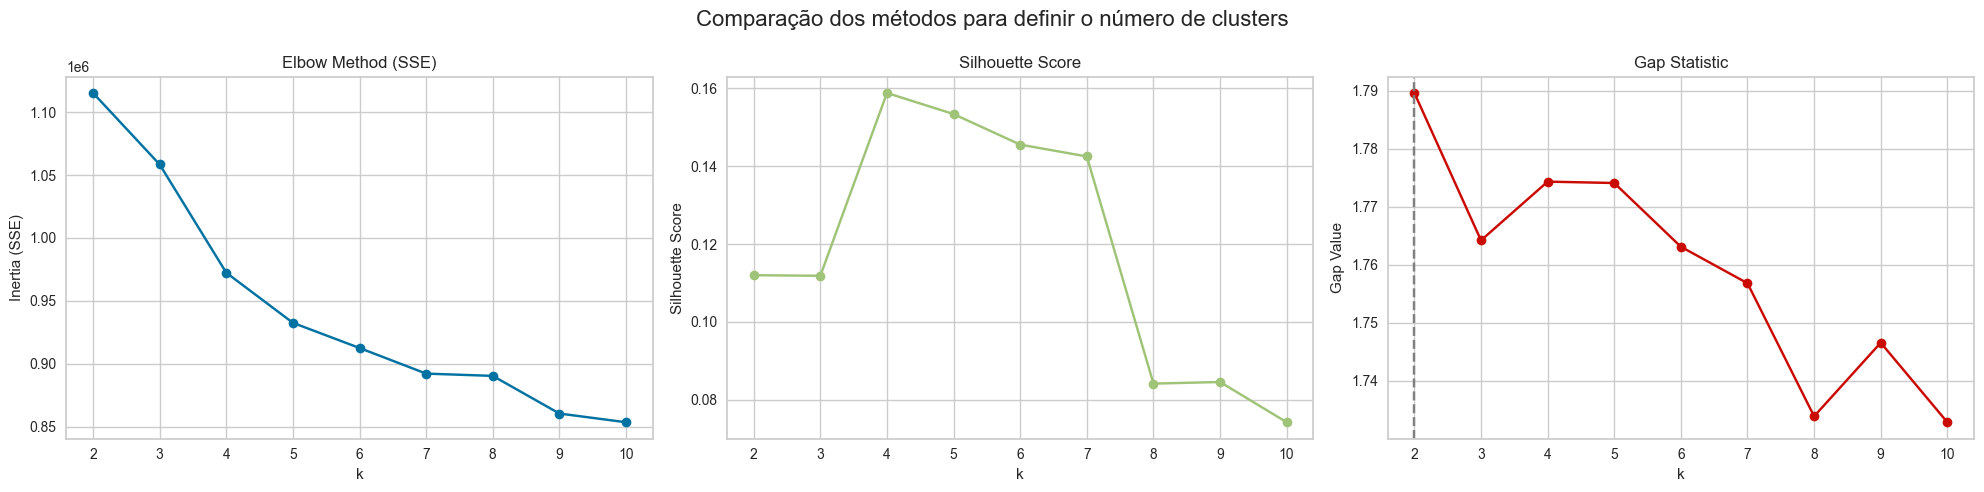

In [419]:
# -------- Plotando os três juntos --------
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Elbow
axs[0].plot(k_range, sse, 'bo-')
axs[0].set_title('Elbow Method (SSE)')
axs[0].set_xlabel('k')
axs[0].set_ylabel('Inertia (SSE)')

# Silhouette
axs[1].plot(k_range, silhouette_scores, 'go-')
axs[1].set_title('Silhouette Score')
axs[1].set_xlabel('k')
axs[1].set_ylabel('Silhouette Score')

# Gap Statistic
axs[2].plot(k_range, gap_values, 'ro-')
axs[2].axvline(x=gap_best_k, color='gray', linestyle='--', label=f'Melhor k = {gap_best_k}')
axs[2].set_title('Gap Statistic')
axs[2].set_xlabel('k')
axs[2].set_ylabel('Gap Value')
# axs[2].legenAd()

plt.suptitle('Comparação dos métodos para definir o número de clusters', fontsize=16)
plt.tight_layout()
plt.show()

Agora que temos o gráfico de comparação entre os métodos de seleção de clusteres, podemos identificar qual seria o melhor k para prosseguir com a clusterização. 
- Elbow Method: Percebemos que há uma quedra drástica na Inertia até o k= 4, depois cai mais um pouco mas não tão bruscamente até o k=6, depois disso a diminuição na Inertia é bem pouca. Então podemos considerar o k sendo 4 ou 6.
- Shilhouette Score: Já para este método, quanto amior o score, melhor, então teríamos um k=4.
- Gap Statistic: O valor mais alto do Gap é em k=2, mas o segundo valor mais alto seria k = 4. 

Desta forma vamos prosseguir com um k = 4.

5.4 Aplicando a clusterização 

In [ ]:
model = KMeans(n_clusters=4, random_state= 42)
y = model.fit_predict(credito_cluster_scaled_df)
y

In [421]:
credito_df_cluster_final = credito_df_cluster.copy()
credito_df_cluster_final['CLUSTER'] = y + 1
credito_df_cluster_final.head()

pf_ou_pj grade sub_grade  qtd_restritivos verificacao_fonte_de_renda  \
0       PF     B        C4                0               Not Verified   
1       PF     C        D3                0            Source Verified   
2       PF     F        D4                0            Source Verified   
3       PF     C        C3                0            Source Verified   
4       PF     C        D4                1            Source Verified   

   razao_credito_tomado_vs_renda_informada  patrimonio_total  \
0                                16.284758      176346.62670   
1                                15.412409       39833.92100   
2                                28.137619       91506.69105   
3                                18.043730      108286.57590   
4                                17.209886       44234.82545   

   qtd_atrasos_ultimos_2a  valor_total_recuperacoes_ultimos_2a  \
0                       1                             2.498291   
1                       0                             2.377215   
2                       0                             4.316277   
3                       1                             0.107020   
4                       1                          1294.818751   

   qtd_consultas_ultimos_6m  qtd_linhas_credito_abertas  saldo_rotativo_total  \
0                         0                          13                 24246   
1                         0                          12                   812   
2                         0                          14                  1843   
3                         0                           7                 13819   
4                         3                          13                  1544   

   limite_rotativo_total  valor_total_emprestimos_tomados  \
0                   6619                            10000   
1                  20885                             3609   
2                  26155                            28276   
3                  60214                            11170   
4                  22579                            16890   

   taxa_juros_media_emprestimos_tomados  target  CLUSTER  
0                             11.135007       0        4  
1                             12.237563       0        3  
2                             12.545884       0        3  
3                             16.731201       0        3  
4                             15.008300       0        1

6.5 Interpretando os clusters formados

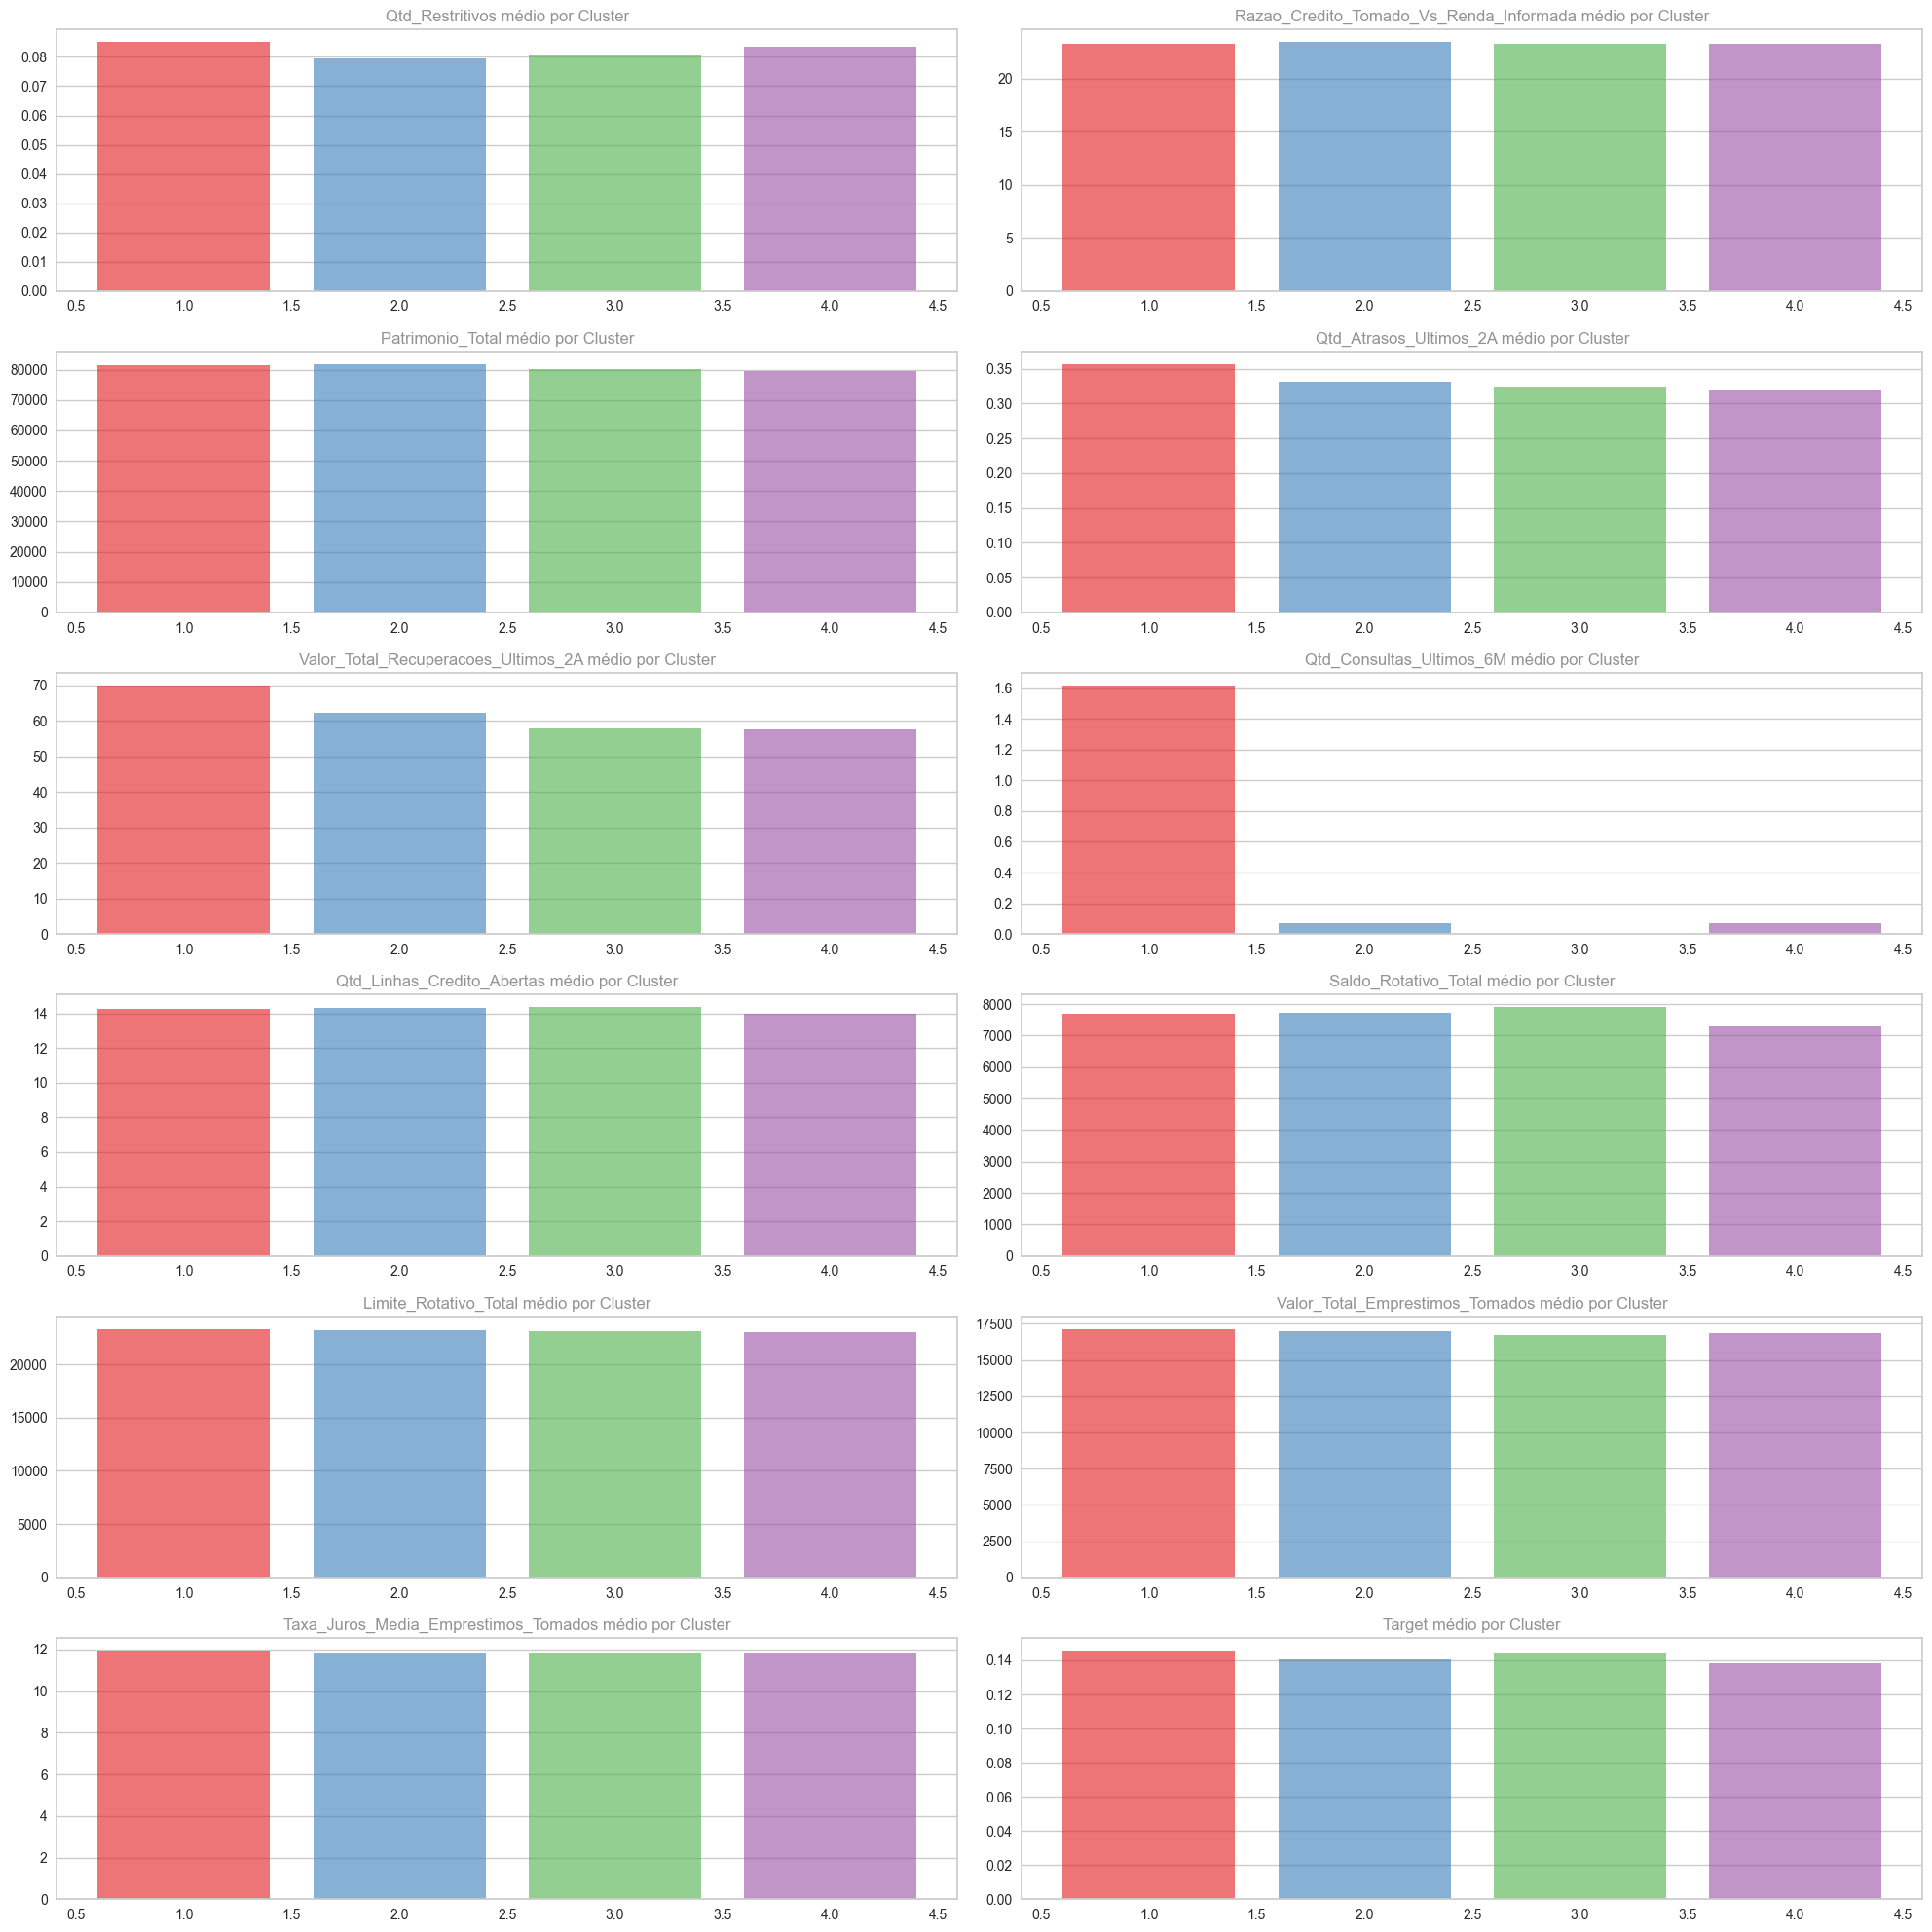

In [422]:
# Para variáveis numéricas
fig = plt.figure(figsize=(20,20))
for i, column in enumerate(col_not_cat):
    df_plot = credito_df_cluster_final.groupby(['CLUSTER'])[column].mean()
    ax = fig.add_subplot(6,2, i+1)
    ax.bar(df_plot.index, df_plot, color = sns.color_palette('Set1'), alpha = 0.6)
    ax.set_title(f'{column.title()} médio por Cluster', alpha = 0.5)
    ax.xaxis.grid(False)

    plt.tight_layout()
plt.show()

In [548]:
credito_df_cluster_final.groupby(['CLUSTER'])[col_not_cat].agg(['mean', 'median', 'std', 'min', 'max', 'sum'])

qtd_restritivos                                 \
                   mean median       std min max   sum   
CLUSTER                                                  
1              0.085097    0.0  0.344845   0   4   394   
2              0.079549    0.0  0.346929   0   4  1384   
3              0.080820    0.0  0.339150   0   4  2393   
4              0.083597    0.0  0.360305   0   4  1323   

        razao_credito_tomado_vs_renda_informada                       \
                                           mean     median       std   
CLUSTER                                                                
1                                     23.277352  22.518870  8.443902   
2                                     23.448367  22.897212  8.387687   
3                                     23.245168  22.564078  8.479569   
4                                     23.242869  22.662073  8.471196   

                                            patrimonio_total               \
              min        max            sum             mean       median   
CLUSTER                                                                     
1        0.961457  39.622861  107774.141844     81424.426064  69823.39776   
2        1.117459  39.627576  407954.689433     81936.831500  70602.67325   
3        0.763630  39.629862  688266.192484     80200.409272  68948.59310   
4        0.675299  39.627864  367841.646113     79387.424454  68363.55806   

                                                               \
                  std          min          max           sum   
CLUSTER                                                         
1        46499.073821  15605.08070  400348.8196  3.769951e+08   
2        45904.845534  14652.37968  405697.0616  1.425537e+09   
3        44353.888253  14678.63863  406561.5364  2.374654e+09   
4        44834.246833  14573.53717  395930.6529  1.256385e+09   

        qtd_atrasos_ultimos_2a                                 \
                          mean median       std min max   sum   
CLUSTER                                                         
1                     0.357019    0.0  0.845463   0   8  1653   
2                     0.331187    0.0  0.815288   0   8  5762   
3                     0.324023    0.0  0.793731   0   8  9594   
4                     0.319727    0.0  0.784534   0   8  5060   

        valor_total_recuperacoes_ultimos_2a                                  \
                                       mean    median         std       min   
CLUSTER                                                                       
1                                 69.906026  3.251046  393.045415  0.002364   
2                                 62.110808  3.205664  355.171439  0.000221   
3                                 57.835744  3.378963  352.414898  0.000036   
4                                 57.515837  3.429985  356.530957  0.000350   

                                   qtd_consultas_ultimos_6m                   \
                 max           sum                     mean median       std   
CLUSTER                                                                        
1        4220.932555  3.236649e+05                 1.616847    2.0  0.672627   
2        4339.261318  1.080604e+06                 0.072652    0.0  0.259572   
3        4354.467419  1.712459e+06                 0.000000    0.0  0.000000   
4        4299.375307  9.102456e+05                 0.068432    0.0  0.252493   

                      qtd_linhas_credito_abertas                           \
        min max   sum                       mean median       std min max   
CLUSTER                                                                     
1         1   5  7486                  14.273002   13.0  6.239217   2  37   
2         0   1  1264                  14.332912   13.0  6.256230   2  37   
3         0   0     0                  14.368807   13.0  6.241483   2  37   
4         0   1  1083                  14.000442   12.0  6.148263  

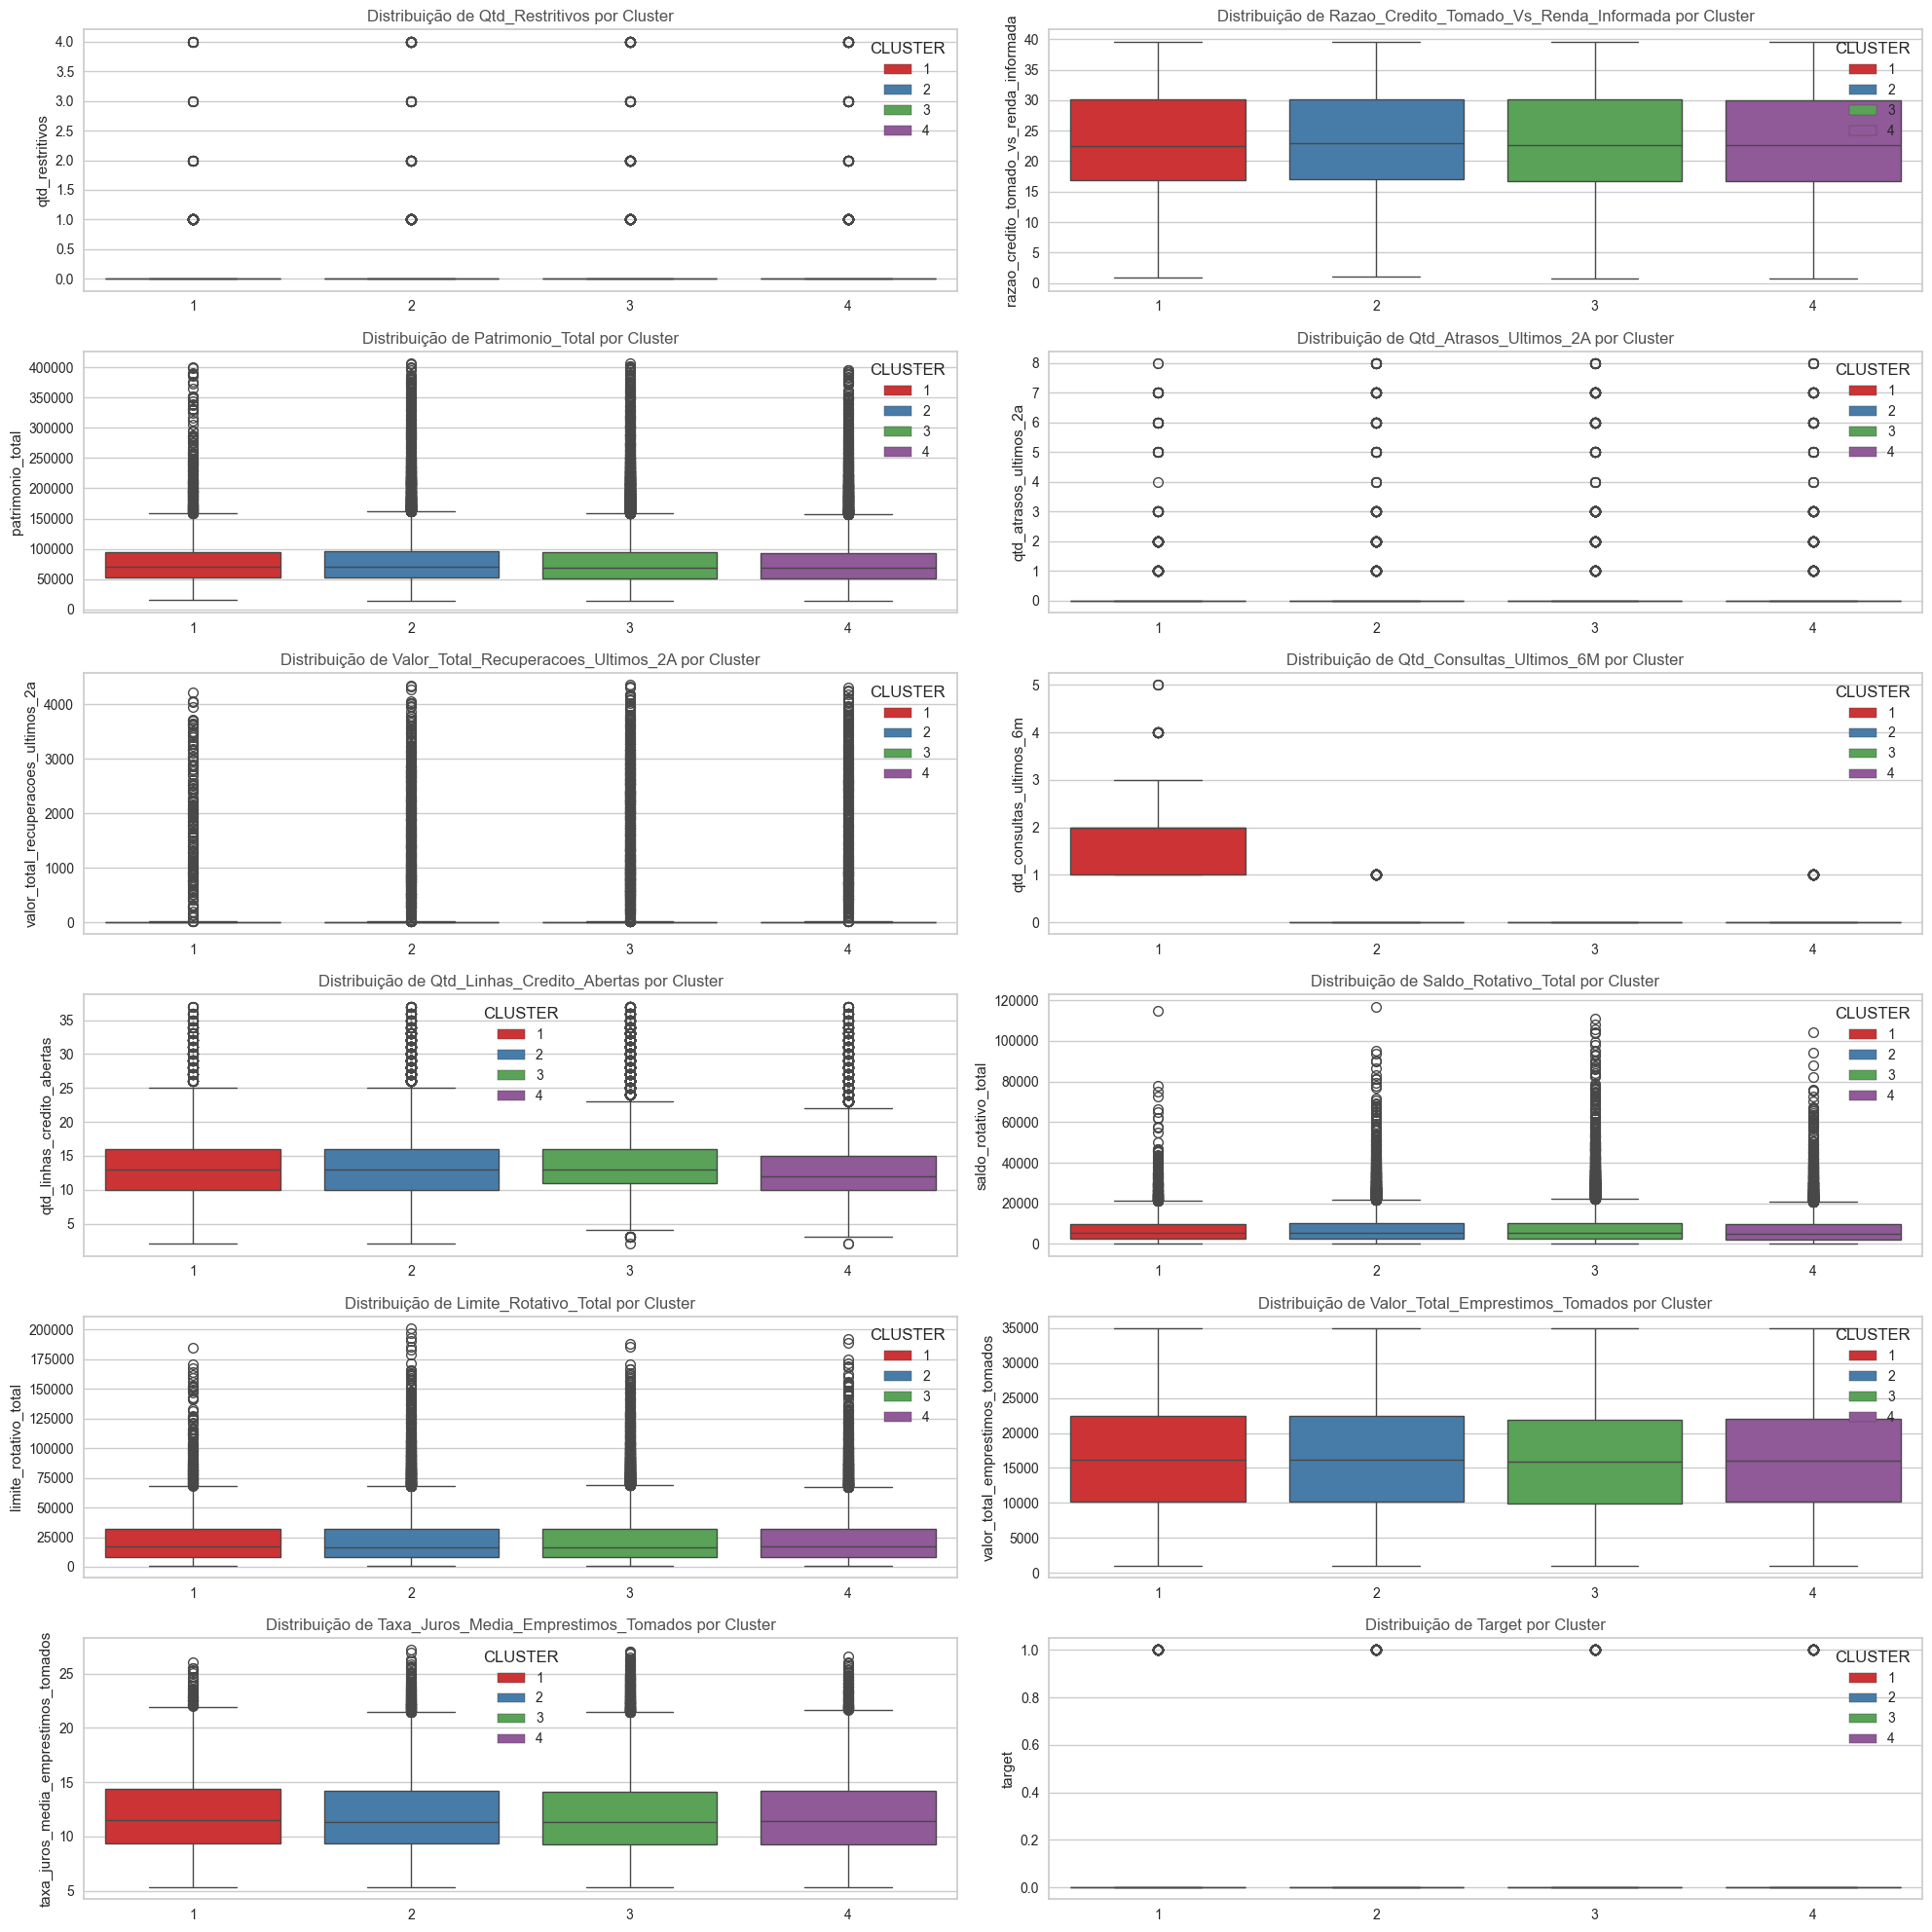

In [424]:
fig = plt.figure(figsize=(20,20))
for i, column in enumerate(col_not_cat):
    ax = fig.add_subplot(6,2, i+1)
    sns.boxplot(x = 'CLUSTER', y = column,
               data = credito_df_cluster_final, palette = 'Set1', hue='CLUSTER', showfliers=True)
    ax.set_title(f'Distribuição de {column.title()} por Cluster', alpha = 0.8)
    ax.set_xlabel('')
    ax.set_ylabel(column)

plt.tight_layout()
plt.show()

<Axes: xlabel='qtd_consultas_ultimos_6m', ylabel='qtd_atrasos_ultimos_2a'>

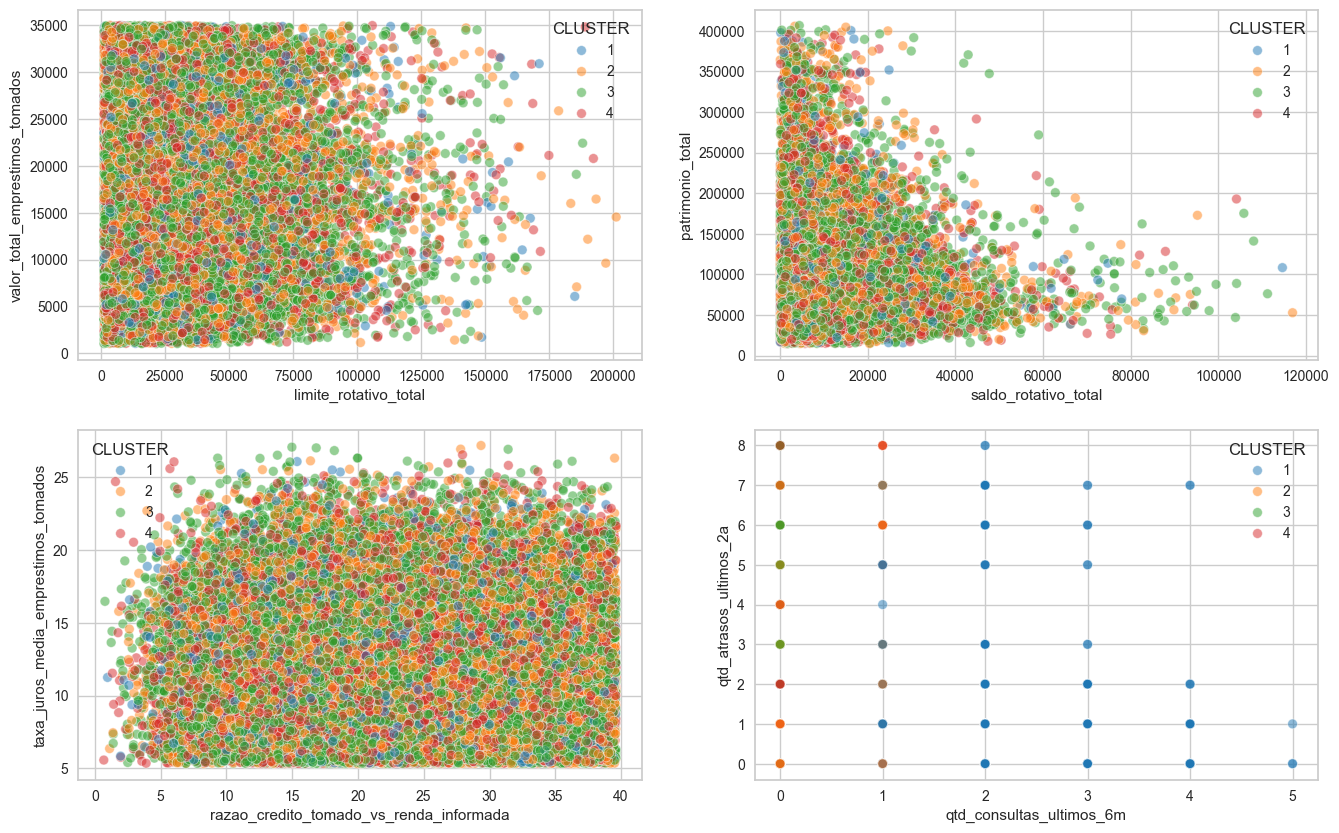

In [425]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
sns.scatterplot(x='limite_rotativo_total', y='valor_total_emprestimos_tomados', hue='CLUSTER',
                data=credito_df_cluster_final, palette='tab10', alpha=0.5, ax=ax1)

sns.scatterplot(x='saldo_rotativo_total', y='patrimonio_total', hue='CLUSTER',
                data=credito_df_cluster_final, palette='tab10', alpha=0.5, ax=ax2)

sns.scatterplot(x='razao_credito_tomado_vs_renda_informada', y='taxa_juros_media_emprestimos_tomados', hue='CLUSTER',
                data=credito_df_cluster_final, palette='tab10', alpha=0.5, ax=ax3)

sns.scatterplot(x='qtd_consultas_ultimos_6m', y='qtd_atrasos_ultimos_2a', hue='CLUSTER',
                data=credito_df_cluster_final, palette='tab10', alpha=0.5, ax=ax4)

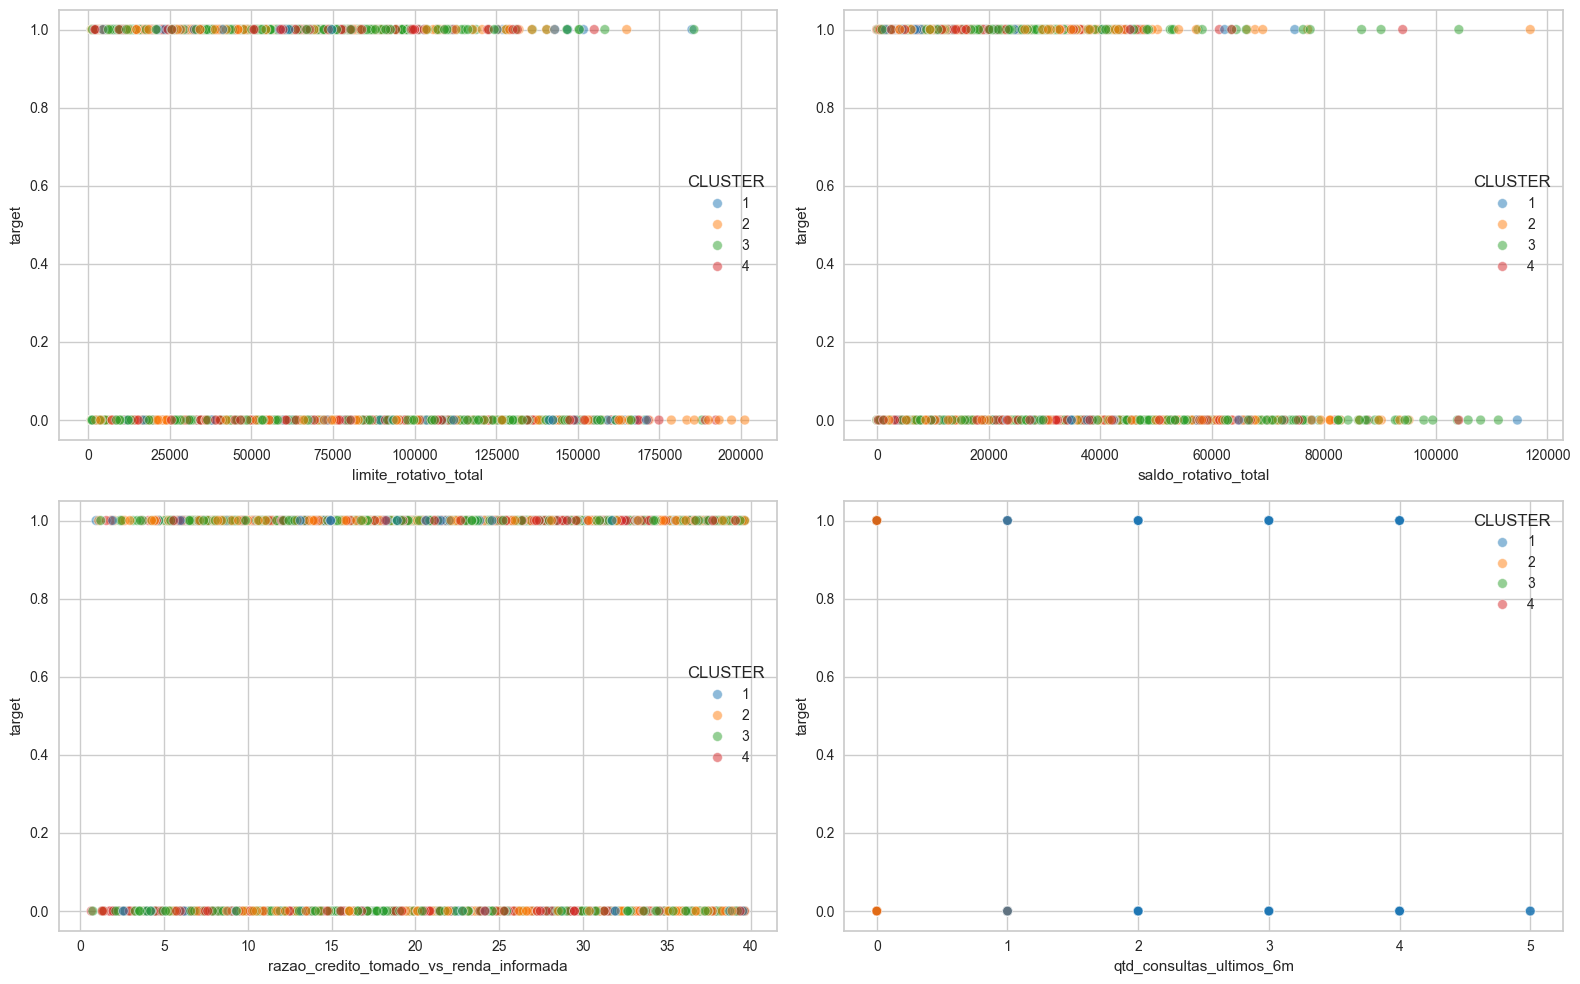

In [426]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

sns.scatterplot(x='limite_rotativo_total', y='target', hue='CLUSTER',
                data=credito_df_cluster_final, palette='tab10', alpha=0.5, ax=ax1)

sns.scatterplot(x='saldo_rotativo_total', y='target', hue='CLUSTER',
                data=credito_df_cluster_final, palette='tab10', alpha=0.5, ax=ax2)

sns.scatterplot(x='razao_credito_tomado_vs_renda_informada', y='target', hue='CLUSTER',
                data=credito_df_cluster_final, palette='tab10', alpha=0.5, ax=ax3)

sns.scatterplot(x='qtd_consultas_ultimos_6m', y='target', hue='CLUSTER',
                data=credito_df_cluster_final, palette='tab10', alpha=0.5, ax=ax4)

plt.tight_layout()
plt.show()


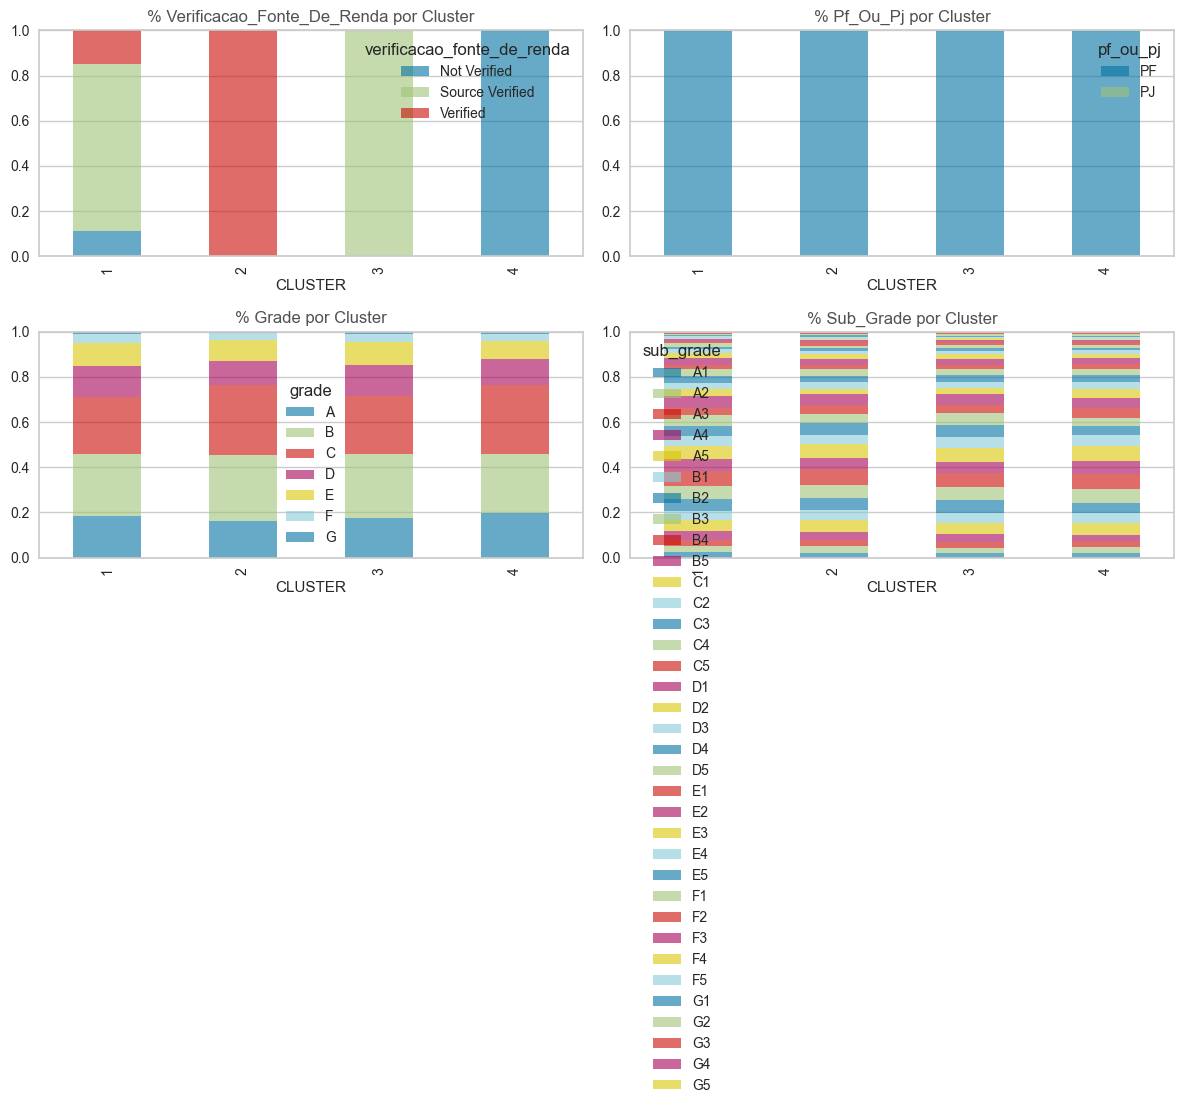

In [ ]:
# Para variáveis categóricas

n = len(dist_cat_cols)
ncols = 2
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))

for i, col in enumerate(dist_cat_cols):
    row = i // ncols
    col_pos = i % ncols
    ax = axes[row, col_pos] if nrows > 1 else axes[col_pos]

    plot_df = pd.crosstab(index=credito_df_cluster_final['CLUSTER'],
                          columns=credito_df_cluster_final[col],
                          normalize='index')

    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
    ax.set_title(f'% {col.title()} por Cluster', alpha=0.8)
    ax.set_ylim(0, 1)
    ax.legend(title=col, frameon=False)
    ax.xaxis.grid(False)

plt.tight_layout()
plt.show()


In [428]:
credito_df_cluster_final.reset_index().groupby(['CLUSTER', 'verificacao_fonte_de_renda'], as_index = False).agg(inadimpl = ('index', 'count'))


CLUSTER verificacao_fonte_de_renda  inadimpl
0        1               Not Verified       523
1        1            Source Verified      3427
2        1                   Verified       680
3        2                   Verified     17398
4        3            Source Verified     29609
5        4               Not Verified     15826

In [ ]:
inadimplencia_count = credito_df_cluster_final.reset_index().groupby(['CLUSTER', 'target'], as_index = False).agg(inadimpl = ('index', 'count'))
inadimplencia_count_total = inadimplencia_count.groupby(['CLUSTER'], as_index = False).agg(total = ('inadimpl', 'sum'))
inadimplencia_count = inadimplencia_count.merge(inadimplencia_count_total, how = 'left', on = 'CLUSTER')
inadimplencia_count['perc'] = round(100*inadimplencia_count['inadimpl']/inadimplencia_count['total'], 2)
inadimplencia_count.sort_values()

CLUSTER  target  inadimpl  total   perc
0        1       0      3955   4630  85.42
1        1       1       675   4630  14.58
2        2       0     14948  17398  85.92
3        2       1      2450  17398  14.08
4        3       0     25349  29609  85.61
5        3       1      4260  29609  14.39
6        4       0     13642  15826  86.20
7        4       1      2184  15826  13.80

In [433]:
credito_df_cluster_final.groupby(['CLUSTER'])[col_not_cat].agg(['mean', 'median', 'std', 'min', 'max', 'sum', 'count'])

qtd_restritivos                                        \
                   mean median       std min max   sum  count   
CLUSTER                                                         
1              0.085097    0.0  0.344845   0   4   394   4630   
2              0.079549    0.0  0.346929   0   4  1384  17398   
3              0.080820    0.0  0.339150   0   4  2393  29609   
4              0.083597    0.0  0.360305   0   4  1323  15826   

        razao_credito_tomado_vs_renda_informada                       \
                                           mean     median       std   
CLUSTER                                                                
1                                     23.277352  22.518870  8.443902   
2                                     23.448367  22.897212  8.387687   
3                                     23.245168  22.564078  8.479569   
4                                     23.242869  22.662073  8.471196   

                                                   patrimonio_total  \
              min        max            sum  count             mean   
CLUSTER                                                               
1        0.961457  39.622861  107774.141844   4630     81424.426064   
2        1.117459  39.627576  407954.689433  17398     81936.831500   
3        0.763630  39.629862  688266.192484  29609     80200.409272   
4        0.675299  39.627864  367841.646113  15826     79387.424454   

                                                                            \
              median           std          min          max           sum   
CLUSTER                                                                      
1        69823.39776  46499.073821  15605.08070  400348.8196  3.769951e+08   
2        70602.67325  45904.845534  14652.37968  405697.0616  1.425537e+09   
3        68948.59310  44353.888253  14678.63863  406561.5364  2.374654e+09   
4        68363.55806  44834.246833  14573.53717  395930.6529  1.256385e+09   

               qtd_atrasos_ultimos_2a                                        \
         count                   mean median       std min max   sum  count   
CLUSTER                                                                       
1         4630               0.357019    0.0  0.845463   0   8  1653   4630   
2        17398               0.331187    0.0  0.815288   0   8  5762  17398   
3        29609               0.324023    0.0  0.793731   0   8  9594  29609   
4        15826               0.319727    0.0  0.784534   0   8  5060  15826   

        valor_total_recuperacoes_ultimos_2a                                  \
                                       mean    median         std       min   
CLUSTER                                                                       
1                                 69.906026  3.251046  393.045415  0.002364   
2                                 62.110808  3.205664  355.171439  0.000221   
3                                 57.835744  3.378963  352.414898  0.000036   
4                                 57.515837  3.429985  356.530957  0.000350   

                                          qtd_consultas_ultimos_6m         \
                 max           sum  count                     mean median   
CLUSTER                                                                     
1        4220.932555  3.236649e+05   4630                 1.616847    2.0   
2        4339.261318  1.080604e+06  17398                 0.072652    0.0   
3        4354.467419  1.712459e+06  29609                 0.000000    0.0   
4        4299.375307  9.102456e+05  15826                 0.068432    0.0   

                                       qtd_linhas_credito_abertas         \
              std min max   sum  count                       mean median   
CLUSTER                                                                    
1        0.672627   1   5  7486   4630                  14.273002   13.0   
2        0.259572   0   1  1264  17398            

In [544]:
cat_grouped_cluster = pd.DataFrame()
for i,col in enumerate(col_not_cat):
    data = credito_df_cluster_final[[col, 'CLUSTER']].reset_index()
    data_grouped = data.groupby(['CLUSTER'], as_index = False)[col].agg(['mean', 'median', 'std', 'min', 'max', 'sum', 'count'])
    data_grouped['var'] = col
    cat_grouped_cluster = pd.concat([cat_grouped_cluster, data_grouped], ignore_index= True)

cat_grouped_cluster.head()

CLUSTER       mean    median       std       min        max            sum  \
0        1   0.085097   0.00000  0.344845  0.000000   4.000000     394.000000   
1        2   0.079549   0.00000  0.346929  0.000000   4.000000    1384.000000   
2        3   0.080820   0.00000  0.339150  0.000000   4.000000    2393.000000   
3        4   0.083597   0.00000  0.360305  0.000000   4.000000    1323.000000   
4        1  23.277352  22.51887  8.443902  0.961457  39.622861  107774.141844   

   count                                      var  
0   4630                          qtd_restritivos  
1  17398                          qtd_restritivos  
2  29609                          qtd_restritivos  
3  15826                          qtd_restritivos  
4   4630  razao_credito_tomado_vs_renda_informada

In [545]:
cat_grouped_cluster = pd.DataFrame()
for i,col in enumerate(dist_cat_cols):
    data = credito_df_cluster_final[[col, 'CLUSTER']].reset_index()
    data_grouped = data.groupby(['CLUSTER', col], as_index = False).agg({'index' : 'count'})
    data_grouped.columns = ['CLUSTER', 'type', 'total']
    data_grouped['var'] = col
    cat_grouped_cluster = pd.concat([cat_grouped_cluster, data_grouped], ignore_index= True)

cat_grouped_cluster.head()

CLUSTER             type  total                         var
0        1     Not Verified    523  verificacao_fonte_de_renda
1        1  Source Verified   3427  verificacao_fonte_de_renda
2        1         Verified    680  verificacao_fonte_de_renda
3        2         Verified  17398  verificacao_fonte_de_renda
4        3  Source Verified  29609  verificacao_fonte_de_renda

In [549]:
cat_grouped_cluster.query("var == 'verificacao_fonte_de_renda'")

CLUSTER             type  total                         var
0        1     Not Verified    523  verificacao_fonte_de_renda
1        1  Source Verified   3427  verificacao_fonte_de_renda
2        1         Verified    680  verificacao_fonte_de_renda
3        2         Verified  17398  verificacao_fonte_de_renda
4        3  Source Verified  29609  verificacao_fonte_de_renda
5        4     Not Verified  15826  verificacao_fonte_de_renda

In [443]:
grade_cluster = credito_df_cluster_final.reset_index().groupby(['CLUSTER', 'grade'], as_index = False).agg({'index' : 'count'}).sort_values(['index'], ascending= False)
# grade_cluster.query()

credito_df_cluster_final.groupby(['CLUSTER', 'grade'])[['CLUSTER', 'grade']].agg([ 'count'])

CLUSTER grade
                count count
CLUSTER grade              
1       A         850   850
        B        1268  1268
        C        1180  1180
        D         626   626
        E         484   484
        F         180   180
        G          42    42
2       A        2830  2830
        B        5034  5034
        C        5442  5442
        D        1828  1828
        E        1606  1606
        F         544   544
        G         114   114
3       A        5254  5254
        B        8283  8283
        C        7621  7621
        D        4042  4042
        E        3063  3063
        F        1030  1030
        G         316   316
4       A        3121  3121
        B        4157  4157
        C        4842  4842
        D        1763  1763
        E        1293  1293
        F         492   492
        G         158   158

In [449]:
credito_df_cluster_final.query("CLUSTER == 1").reset_index().groupby(['CLUSTER', 'sub_grade'], as_index = False).agg({'index' : 'count'}).sort_values(['index'], ascending= False).head(5)

CLUSTER sub_grade  index
8         1        B4    319
7         1        B3    262
10        1        C1    254
6         1        B2    253
15        1        D1    245

In [550]:
credito_df_cluster_final.query("CLUSTER == 4").reset_index().groupby(['CLUSTER', 'sub_grade'], as_index = False).agg({'index' : 'count'}).sort_values(['index'], ascending= False).head(5)

CLUSTER sub_grade  index
8         4        B4   1097
10        4        C1   1022
7         4        B3    980
9         4        B5    903
4         4        A5    848

In [ ]:


for col in col_not_cat:
    grupos = [credito_df_cluster_final[credito_df_cluster_final['CLUSTER'] == c][col] for c in credito_df_cluster_final['CLUSTER'].unique()]
    stat, p = f_oneway(*grupos)
    print(f"{col}: p-valor = {p:.4f}")

qtd_restritivos: p-valor = 0.6280
razao_credito_tomado_vs_renda_informada: p-valor = 0.0612
patrimonio_total: p-valor = 0.0000
qtd_atrasos_ultimos_2a: p-valor = 0.0337
valor_total_recuperacoes_ultimos_2a: p-valor = 0.1128
qtd_consultas_ultimos_6m: p-valor = 0.0000
qtd_linhas_credito_abertas: p-valor = 0.0000
saldo_rotativo_total: p-valor = 0.0000
limite_rotativo_total: p-valor = 0.7840
valor_total_emprestimos_tomados: p-valor = 0.0001
taxa_juros_media_emprestimos_tomados: p-valor = 0.1793
target: p-valor = 0.2999


Com base nas métricas e gráficos apresentados referente aos grupos formados utilizando o algoritmo KMeans a k = 4, temos a seguinte interpretação comportamental e de risco:

- Cluster 1: Perfil de Maior Risco
    - Categóricos:
        - Predominância de clientes Source Verified e Verified, mas ainda com uma fração significativa de Not Verified.
        - Composição majoritariamente de PF (Pessoa Física).
    - Numéricos:
        - Tem a maior média de restritivos e também a maior proporção de inadimplentes (14.58%)

- Cluster 2: Perfil mais Seguro com Documentação Forte
    - Categóricos:
        - Todos os clientes são Verified, sugerindo alta confiabilidade documental.
        - Exclusivamente PF, sem presença de Not Verified ou Source Verified.
    - Numéricos:
        - Apresenta os menores valores médios de variáveis de risco (como restritivos e razão crédito/renda), sugerindo perfil mais seguro e estável.
        - Segundo menor proporção de inadimplência: 14.08%

- Cluster 3: Perfil Comum e Diversificado
    - Categóricos:
        - Alta proporção de Source Verified, semelhante ao Cluster 1, mas sem Not Verified.
        - Composição também inteiramente de PF.
    - Numéricos:
        - Os valores médios são intermediários entre os demais clusters.
        - Pode representar a massa majoritária dos clientes com risco e documentação balanceados.

- Cluster 4: Perfil documental fraco, mas baixo risco
    - Categóricos:
        - Todos os clientes são Not Verified.
    - Numéricos:
        - Apresenta a menor proporção de inadimplência (13.80%)
        - Segunda menor média de qtd_restritivos (0.0836)




**Validação estatística dos cluster**  
Para validar a segmentação obtida via KMeans, foi conduzida uma análise de variância (ANOVA) entre os grupos para todas as variáveis numéricas. Os resultados indicam que diversas variáveis apresentam diferenças estatisticamente significativas entre os clusters (p < 0.05), como:

- patrimônio_total (p < 0.0001),

- qtd_atrasos_ultimos_2a (p = 0.0337),

- qtd_consultas_ultimos_6m,

- qtd_linhas_credito_abertas,

- saldo_rotativo_total,

- e valor_total_emprestimos_tomados (todas com p < 0.0001).

Esses resultados reforçam que os clusters não apenas se diferenciam com base em proximidade nos dados, mas também representam grupos com perfis financeiros significativamente distintos. Variáveis como patrimônio_total e saldo_rotativo_total, por exemplo, contribuem diretamente para caracterizar o comportamento de crédito dos grupos. Por outro lado, variáveis como qtd_restritivos, limite_rotativo_total e a própria target não apresentaram diferenças estatisticamente significativas entre os clusters, o que indica que não são determinantes na formação dos grupos.

Conclusão:
O objetivo da clusterização foi identificar perfis distintos de clientes com base em características associadas ao risco de crédito. Utilizando K=4, a segmentação revelou grupos com diferenças relevantes. O Cluster 1 concentrou a maior taxa de inadimplência e apresentou indicadores de maior risco, como menor comprovação de renda e maiores restritivos. Em contraste, o Cluster 2 mostrou-se mais seguro, com alta proporção de clientes adimplentes, boa documentação e valores de empréstimo mais equilibrados. Os Clusters 3 e 4 apresentaram perfis intermediários, sendo que o Cluster 4, apesar da documentação fraca (todos "Not Verified"), surpreendentemente exibiu a menor taxa de inadimplência. Embora não tenha havido uma divisão binária clara entre adimplentes e inadimplentes, a segmentação revelou diferentes níveis de risco e padrões de comportamento financeiro, fornecendo subsídios para políticas de crédito mais direcionadas e estratégias de mitigação de risco mais eficazes.

Sugestão:
Algo que poderia melhorar a criação de grupos para segmentação dos clientes seria a utilização de variáveis comportamentais e sociais, como:
- Idade
- Gênero
- Estado civil
- Escolaridade
- Número de dependentes
- Ocupação
- Localização geográfica

Isso poderia apresentar um maior número de grupos distintos, ou aumentar o grau de diferenciação entre uma nova leva de agrupamento.

#### 6. Classificação

6.1 Criando train/Test Split

Para não causar data leakage, faremos a separação dos dados de treino e teste com os dados puros sem nenhum tipo de transformação. 

In [466]:
credito_df.query('target.isnull()')

Empty DataFrame
Columns: [client_id, pf_ou_pj, grade, sub_grade, qtd_restritivos, verificacao_fonte_de_renda, razao_credito_tomado_vs_renda_informada, patrimonio_total, qtd_atrasos_ultimos_2a, valor_total_recuperacoes_ultimos_2a, contas_distintas_com_atraso, qtd_consultas_ultimos_6m, qtd_linhas_credito_abertas, saldo_rotativo_total, limite_rotativo_total, valor_total_emprestimos_tomados, taxa_juros_media_emprestimos_tomados, target]
Index: []

In [467]:
# Criando uma cópia dos dados
X = credito_df.copy()
y = credito_df['target']

# Removendo a variável target de X
X.drop(columns = ['target'], inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 42)



In [468]:
# Removendo colunas que não serão usadas 
X_train2 = X_train.drop(columns= colunas_para_deletar) 

In [ ]:
colunas_para_deletar

In [469]:
# Vamos checar se a proporção dos dados está correta
train_ratio = round(100*y_train.sum()/len(y_train),2 )
test_ratio = round(100*y_test.sum()/len(y_test), 2)

print(f'Razão da classe positiva nos dados de treino: {train_ratio}%')
print(f'Razão da classe positiva nos dados de teste: {test_ratio}%')

Razão da classe positiva nos dados de treino: 14.21%
Razão da classe positiva nos dados de teste: 14.07%


6.2 Correlação

In [470]:
eda_train_data = X_train2.copy()
eda_train_data['target'] = y_train

<Axes: >

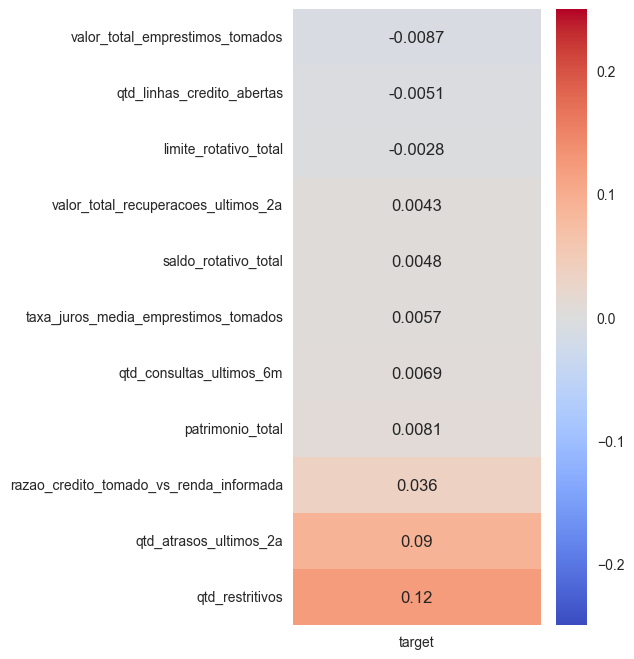

In [471]:
# Vamos ver quais das variáveis tem corrlação com a target 
corr_matrix = eda_train_data.corr(numeric_only= True).sort_values(['target'], ascending = True)
corr_matrix_sem_target = corr_matrix.drop('target')

# Criando um heatmap
fig, ax = plt.subplots(figsize = (4,8))
sns.heatmap(corr_matrix_sem_target[['target']], cmap= 'coolwarm', annot= True, vmax = 0.25, vmin = -0.25)


As análises de correlação entre as variáveis numéricas e a inadimplência revelam padrões interessantes. As variáveis que mais se correlacionam positivamente com o status de inadimplente são a quantidade de restritivos, a quantidade de atrasos nos últimos 2 anos e a razão entre o crédito tomado e a renda informada. Ainda que essas correlações sejam consideradas fracas (valores inferiores a 0.15), elas indicam uma tendência: quanto maior o número de restrições, atrasos e a proporção de crédito em relação à renda, maior a probabilidade de inadimplência. As demais variáveis numéricas apresentaram correlações próximas de zero, sugerindo uma relação muito fraca ou inexistente com a inadimplência.

In [472]:
for i, col in enumerate(dist_cat_cols):
    tabela = pd.crosstab(eda_train_data[col], eda_train_data['target'])
    chi2, p, dof, expected = chi2_contingency(tabela)

    print(f'{col} p-valor : {p}')
    if p <0.05:
        print(f"Há evidências estatísticas de associação entre {col} e target.")
    else:
        print(f"Não há evidências estatísticas para comprovar a associação entre {col} e target.")




verificacao_fonte_de_renda p-valor : 0.23357001563183336
Não há evidências estatísticas para comprovar a associação entre verificacao_fonte_de_renda e target.
pf_ou_pj p-valor : 0.5993106666685617
Não há evidências estatísticas para comprovar a associação entre pf_ou_pj e target.
grade p-valor : 8.913841397780745e-204
Há evidências estatísticas de associação entre grade e target.
sub_grade p-valor : 0.7720297283090524
Não há evidências estatísticas para comprovar a associação entre sub_grade e target.


Durante a etapa de análise exploratória orientada à modelagem de classificação, buscamos identificar quais variáveis mais contribuem para a diferenciação entre clientes inadimplentes e adimplentes.

Entre as variáveis numéricas, destacam-se aquelas com correlação positiva (ainda que fraca) com a variável alvo (target): a quantidade de restritivos, a quantidade de atrasos nos últimos 2 anos e a razão entre o crédito tomado e a renda informada. Esses atributos ajudam a indicar um padrão de maior risco: clientes com histórico de restrições, maior frequência de atrasos e comprometimento elevado da renda com dívidas tendem a apresentar maior probabilidade de inadimplência. Embora os coeficientes de correlação sejam baixos (inferiores a 0.15), eles apontam caminhos úteis para os modelos classificatórios.

Nas variáveis categóricas, apenas a variável grade demonstrou associação estatisticamente significativa com a inadimplência, segundo o teste do qui-quadrado (p < 0.05). Isso indica que a classificação de risco atribuída por grade possui relação com o comportamento de crédito dos clientes, sendo um fator importante para a modelagem. Já as variáveis verificacao_fonte_de_renda, pf_ou_pj e sub_grade não apresentaram significância estatística.

Todas as variáveis disponíveis foram utilizadas na modelagem, com o objetivo de capturar o máximo de informações possíveis no primeiro ciclo de desenvolvimento. No entanto, como sugestão para etapas futuras de otimização, recomenda-se a aplicação de técnicas de seleção de variáveis, como Recursive Feature Elimination (RFE) ou regularização (Lasso), para melhorar a performance e a interpretabilidade dos modelos, focando nos atributos que realmente contribuem para a predição da inadimplência.

6.3 Feature encoding nas variáveis categóricas

In [477]:
X_train2[dist_cat_cols].nunique()

verificacao_fonte_de_renda     3
pf_ou_pj                       2
grade                          7
sub_grade                     35
dtype: int64

In [478]:
# Utilizando o encoding que já foi criado anteriormente
# Encoding variáveis ordinais
ord_encoded_train  = ord_encoder.fit_transform(X_train2[cat_cols_ord])

# Encoding variáveis binárias
bin_encoded_train = bin_encoder.fit_transform(X_train2[cat_cols_bin])

# Encoding variáveis com one hot
one_hot_endoded_train = one_hot_encoder.fit_transform(X_train2[cat_cols_one_hot])

In [479]:
# Juntando todas as variávies categóricas após o encoding
cat_df_encoded = pd.DataFrame()

for data, colu_names in zip([ord_encoded_train, bin_encoded_train, one_hot_endoded_train],
                            [cat_cols_ord, cat_cols_bin, one_hot_encoder.get_feature_names_out()]):
    df = pd.DataFrame(data, index = X_train2.index)
    df.columns = colu_names

    cat_df_encoded = pd.concat([cat_df_encoded, df], axis = 1)

cat_df_encoded

grade  sub_grade  pf_ou_pj  verificacao_fonte_de_renda_Not Verified  \
12727    3.0       20.0       0.0                                      0.0   
466      2.0       14.0       0.0                                      1.0   
49785    0.0        3.0       0.0                                      0.0   
32791    1.0       19.0       0.0                                      0.0   
795      3.0        8.0       0.0                                      1.0   
...      ...        ...       ...                                      ...   
37194    0.0       15.0       0.0                                      0.0   
6265     2.0       34.0       0.0                                      0.0   
54886    0.0       22.0       0.0                                      1.0   
860      0.0       14.0       0.0                                      1.0   
15795    0.0       15.0       0.0                                      0.0   

       verificacao_fonte_de_renda_Source Verified  \
12727                                         1.0   
466                                           0.0   
49785                                         1.0   
32791                                         1.0   
795                                           0.0   
...                                           ...   
37194                                         1.0   
6265                                          1.0   
54886                                         0.0   
860                                           0.0   
15795                                         1.0   

       verificacao_fonte_de_renda_Verified  
12727                                  0.0  
466                                    0.0  
49785                                  0.0  
32791                                  0.0  
795                                    0.0  
...                                    ...  
37194                                  0.0  
6265                                   0.0  
54886                                  0.0  
860                                    0.0  
15795                                  0.0  

[53970 rows x 6 columns]

In [551]:
numerical_cols = [x for x in col_not_cat if x != 'target']

In [481]:
# Juntando variáveis numéricas e categóricas
X_train_encoded = pd.concat([X_train2[numerical_cols], cat_df_encoded], axis = 1)
X_train_encoded.head()

qtd_restritivos  razao_credito_tomado_vs_renda_informada  \
12727                0                                11.390727   
466                  0                                38.924679   
49785                0                                30.880622   
32791                0                                28.155703   
795                  0                                25.846773   

       patrimonio_total  qtd_atrasos_ultimos_2a  \
12727      100291.04780                       0   
466         40568.27953                       0   
49785       50747.84740                       0   
32791       61070.10310                       1   
795        177365.49260                       2   

       valor_total_recuperacoes_ultimos_2a  qtd_consultas_ultimos_6m  \
12727                             0.380896                         0   
466                               6.274840                         0   
49785                             1.070807                         0   
32791                             0.244698                         0   
795                               5.484804                         0   

       qtd_linhas_credito_abertas  saldo_rotativo_total  \
12727                          14                  4559   
466                             7                   784   
49785                          12                 10327   
32791                          14                  2452   
795                            31                 14495   

       limite_rotativo_total  valor_total_emprestimos_tomados  \
12727                  18796                            16525   
466                    13867                            15660   
49785                  35872                            27107   
32791                  25620                            22649   
795                    20947                            15496   

       taxa_juros_media_emprestimos_tomados  grade  sub_grade  pf_ou_pj  \
12727                             11.009838    3.0       20.0       0.0   
466                               15.602964    2.0       14.0       0.0   
49785                             10.132380    0.0        3.0       0.0   
32791                             14.537668    1.0       19.0       0.0   
795                               17.844327    3.0        8.0       0.0   

       verificacao_fonte_de_renda_Not Verified  \
12727                                      0.0   
466                                        1.0   
49785                                      0.0   
32791                                      0.0   
795                                        1.0   

       verificacao_fonte_de_renda_Source Verified  \
12727                                         1.0   
466                                           0.0   
49785                                         1.0   
32791                                         1.0   
795                                           0.0   

       verificacao_fonte_de_renda_Verified  
12727                                  0.0  
466                                    0.0  
49785                                  0.0  
32791                                  0.0  
795                                    0.0

6.4 Dummy variable trap

A dummy variable trap ocorre quando você cria variáveis dummies (via one-hot encoding) e mantém todas as categorias, gerando colinearidade entre elas. Vamos testar se as variáveis geradas com esse método cairam nessa regra.

In [483]:
# Dummy variable trap 
# Função que calcula a Variance Inflation Feature
def calculte_vif(dataframe):
    # Adicionando constante ao df
    df_with_constant = add_constant(dataframe)

    # Calculando VIF para cada variável
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df_with_constant.columns
    vif_data['VIF'] = [variance_inflation_factor(df_with_constant.values, i) for i in range(df_with_constant.shape[1])]

    return vif_data

# Calculate VIF
vif_df = calculte_vif(X_train_encoded)
vif_df

c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



Feature       VIF
0                                        const  0.000000
1                              qtd_restritivos  1.001127
2      razao_credito_tomado_vs_renda_informada  1.001507
3                             patrimonio_total  1.002090
4                       qtd_atrasos_ultimos_2a  1.001062
5          valor_total_recuperacoes_ultimos_2a  1.001151
6                     qtd_consultas_ultimos_6m  1.000863
7                   qtd_linhas_credito_abertas  1.001293
8                         saldo_rotativo_total  1.004408
9                        limite_rotativo_total  1.001716
10             valor_total_emprestimos_tomados  1.000960
11        taxa_juros_media_emprestimos_tomados  1.001359
12                                       grade  1.004188
13                                   sub_grade  1.001129
14                                    pf_ou_pj  1.000354
15     verificacao_fonte_de_renda_Not Verified       inf
16  verificacao_fonte_de_renda_Source Verified       inf
17         verificacao_fonte_de_renda_Verified       inf

Podemos ver que as variáveis que usamos one-hot encoding apresentam perfeita multicolinearidade. Existe uma solução simples para que possamos corrigir isso que seria apagar uma das variáveis gerada, fazendo isso a variável que foi apagada seria identificada implicitamente.

In [484]:
X_train_encoded.drop(columns = ['verificacao_fonte_de_renda_Not Verified'], inplace= True)

In [485]:
# verificando o VIF novamente
vif_df = calculte_vif(X_train_encoded)
vif_df

Feature        VIF
0                                        const  39.994170
1                              qtd_restritivos   1.001127
2      razao_credito_tomado_vs_renda_informada   1.001507
3                             patrimonio_total   1.002090
4                       qtd_atrasos_ultimos_2a   1.001062
5          valor_total_recuperacoes_ultimos_2a   1.001151
6                     qtd_consultas_ultimos_6m   1.000863
7                   qtd_linhas_credito_abertas   1.001293
8                         saldo_rotativo_total   1.004408
9                        limite_rotativo_total   1.001716
10             valor_total_emprestimos_tomados   1.000960
11        taxa_juros_media_emprestimos_tomados   1.001359
12                                       grade   1.004188
13                                   sub_grade   1.001129
14                                    pf_ou_pj   1.000354
15  verificacao_fonte_de_renda_Source Verified   1.550039
16         verificacao_fonte_de_renda_Verified   1.548516

In [486]:
# Alguns modelos que testaremos se beneficiam com a standardização dos dados, então criaremos um segundo dado de treino
# que faz uso dessa transformação

scaler = StandardScaler()

# Ajusta nos dados de treino e transforma
X_train_scaled = scaler.fit_transform(X_train_encoded)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns= X_train_encoded.columns, index= X_train_encoded.index)

X_train_scaled_df.head()


qtd_restritivos  razao_credito_tomado_vs_renda_informada  \
12727        -0.233174                                -1.409492   
466          -0.233174                                 1.851615   
49785        -0.233174                                 0.898881   
32791        -0.233174                                 0.576143   
795          -0.233174                                 0.302674   

       patrimonio_total  qtd_atrasos_ultimos_2a  \
12727          0.431422               -0.409178   
466           -0.885345               -0.409178   
49785         -0.660906               -0.409178   
32791         -0.433321                0.836779   
795            2.130759                2.082735   

       valor_total_recuperacoes_ultimos_2a  qtd_consultas_ultimos_6m  \
12727                            -0.165407                 -0.306776   
466                              -0.148896                 -0.306776   
49785                            -0.163475                 -0.306776   
32791                            -0.165789                 -0.306776   
795                              -0.151110                 -0.306776   

       qtd_linhas_credito_abertas  saldo_rotativo_total  \
12727                   -0.045640             -0.403556   
466                     -1.167244             -0.884988   
49785                   -0.366098              0.332047   
32791                   -0.045640             -0.672265   
795                      2.678255              0.863598   

       limite_rotativo_total  valor_total_emprestimos_tomados  \
12727              -0.207726                        -0.040440   
466                -0.442618                        -0.143879   
49785               0.606033                         1.224979   
32791               0.117472                         0.691881   
795                -0.105220                        -0.163490   

       taxa_juros_media_emprestimos_tomados     grade  sub_grade  pf_ou_pj  \
12727                             -0.224545  0.859905   1.081822 -0.043728   
466                                1.011527  0.136391   0.272947 -0.043728   
49785                             -0.460681 -1.310636  -1.209990 -0.043728   
32791                              0.724841 -0.587123   0.947009 -0.043728   
795                                1.614707  0.859905  -0.535927 -0.043728   

       verificacao_fonte_de_renda_Source Verified  \
12727                                    1.020821   
466                                     -0.979604   
49785                                    1.020821   
32791                                    1.020821   
795                                     -0.979604   

       verificacao_fonte_de_renda_Verified  
12727                            -0.606594  
466                              -0.606594  
49785                            -0.606594  
32791                            -0.606594  
795                              -0.606594

6.5 Seleção do modelo de classificação

In [487]:
# Definindo classificadores para testar
clfs = [
    ('Logistic Regression', LogisticRegression(solver = 'liblinear', max_iter = 2000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(random_state = 42)),
    ('Linear SVM', LinearSVC(random_state= 42, max_iter= 1000, dual = 'auto')),
    ('XGBoost', XGBClassifier(random_state = 42)),
    ('AdaBoost', AdaBoostClassifier(random_state= 42)),
    ('Gradient Boost', GradientBoostingClassifier(random_state= 42)),
    ('Bagging', BaggingClassifier(random_state = 42)),
    ('CatBoost', CatBoostClassifier(random_state = 42, verbose = 0))
]

In [488]:
# Criando um objeto KFold
kf = KFold(n_splits= 10, shuffle= True, random_state= 42)

# Dicionário para guardar os resultados
resultados = {}

# Avaliando cada classificador usando cross validation
for clf_name, clf in clfs:
    if clf_name in ['Logistic Regression', 'Linear SVM', 'KNN']:
        df_X = X_train_scaled_df 
    else:
        df_X = X_train_encoded
    cv_scores = cross_val_score(clf, df_X, y_train, cv = kf, scoring = 'roc_auc')
    resultados[clf_name] = cv_scores

cv_scores_df = pd.DataFrame(resultados)

Text(0.5, 1.0, 'Cross-Validation Scores para diferentes classificadores')

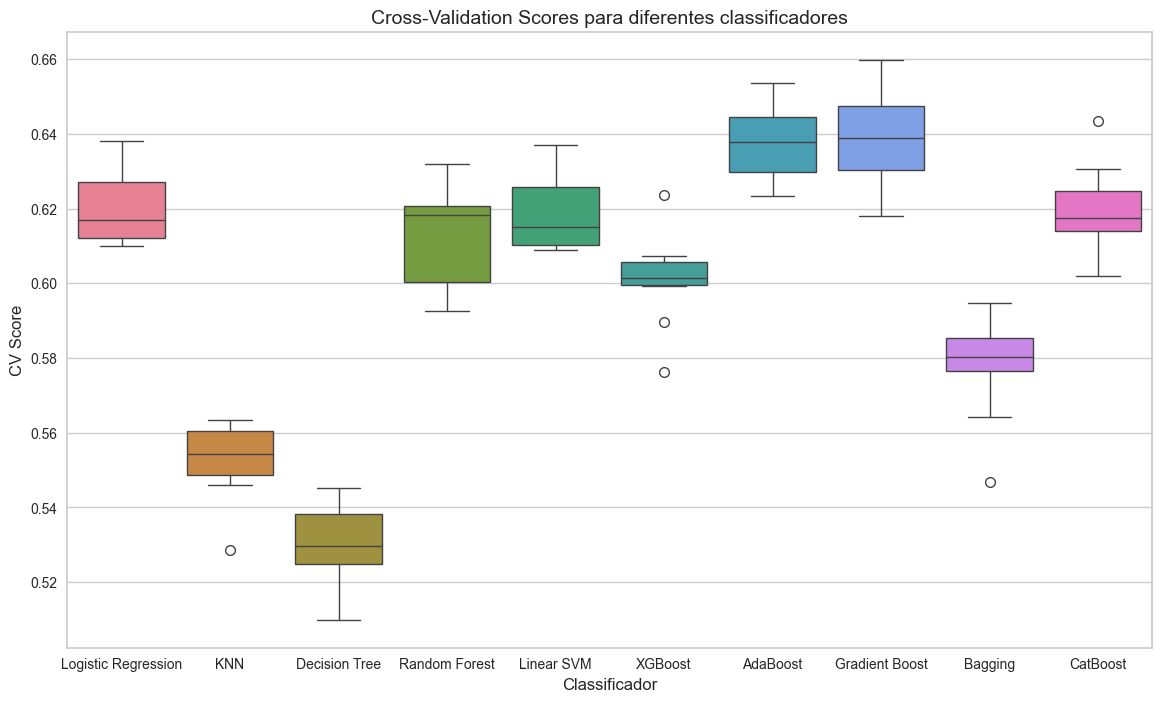

In [489]:
# Plotando os scores
fig, ax = plt.subplots(figsize = (14,8))
sns.boxplot(cv_scores_df)

# Add axis labels
ax.set_xlabel('Classificador', fontsize = 12)
ax.set_ylabel('CV Score', fontsize = 12)
ax.set_title('Cross-Validation Scores para diferentes classificadores', fontsize = 14)


In [492]:
cv_scores_df.mean().sort_values(ascending=False)


Gradient Boost         0.638461
AdaBoost               0.637863
Logistic Regression    0.620666
CatBoost               0.619668
Linear SVM             0.619220
Random Forest          0.612888
XGBoost                0.601024
Bagging                0.577908
KNN                    0.552787
Decision Tree          0.528988
dtype: float64

In [493]:
cv_scores_df.std().sort_values()


AdaBoost               0.009784
KNN                    0.010461
Logistic Regression    0.010612
Linear SVM             0.010657
CatBoost               0.011541
Decision Tree          0.011926
XGBoost                0.012213
Gradient Boost         0.013606
Random Forest          0.013766
Bagging                0.013820
dtype: float64

Para avaliar o desempenho dos modelos de classificação, foi utilizada a métrica ROC AUC (Área sob a Curva ROC). Essa métrica foi escolhida por ser particularmente adequada em contextos de classificação binária com classes desbalanceadas, como é o caso da inadimplência. Ao invés de considerar apenas uma classe corretamente prevista (como faz a acurácia), o ROC AUC avalia a capacidade do modelo em distinguir entre positivos e negativos, levando em conta as taxas de verdadeiros positivos e falsos positivos em diferentes limiares de decisão. Isso fornece uma visão mais abrangente da capacidade discriminativa do modelo, independentemente do threshold adotado, sendo, portanto, uma métrica mais robusta e informativa para esse tipo de problema.   

Além disso, durante o pré-processamento dos dados, foi aplicada a padronização (standardization) para os modelos baseados em distância ou sensíveis à escala das variáveis, como Logistic Regression, Linear SVM e K-Nearest Neighbors (KNN). Esses algoritmos assumem que as variáveis de entrada estão na mesma escala, sendo influenciados por diferenças de magnitude entre as features. Já para modelos como Gradient Boosting e AdaBoost, a padronização não foi necessária, pois esses algoritmos são baseados em árvores de decisão, que são invariantes à escala das variáveis, ou seja, seu desempenho não é afetado por valores em escalas diferentes. Essa abordagem garante que cada modelo receba os dados na forma mais apropriada para seu funcionamento interno, contribuindo para uma avaliação mais justa e eficaz.

Pelo roc auc médio os melhores modelos são
1. Gradient Boost - 0.6385
2. AdaBoost - 0.6378
3. Logistic Regression - 0.6206

Estes são os modelos mais discriminativos, ou seja, que melhor separam inadimplentes e adimplentes. A métrica padrão, que seria a accuracy, pode ser enganosa para problemas de classificação desbalanceada (como inadimplência). Neste caso é melhor usar métricas como roc_auc, f1 ou recall.
Porém, não é somente o auc médio que devemos verificar para selecionar o modelo. É preciso também verificar qual deles possui o menor desvio padrão, pois ele é o mais consistente nos diferentes folds.

Destes modelos acima aqui estão o desvio padrão de cada um:
1. AdaBoost - 0.0098
2. Logistic Regression - 0.0106
3. Gradient Boost - 0.0136

Desta forma vemos que o AdaBoost possui um equilíbrio entre desempenho e estabilidade. Nós podemos, então testar a Regressão Logística, AdaBoost e o Gradient Boost e comparar as métricas.

#### 7. Feature Engineering

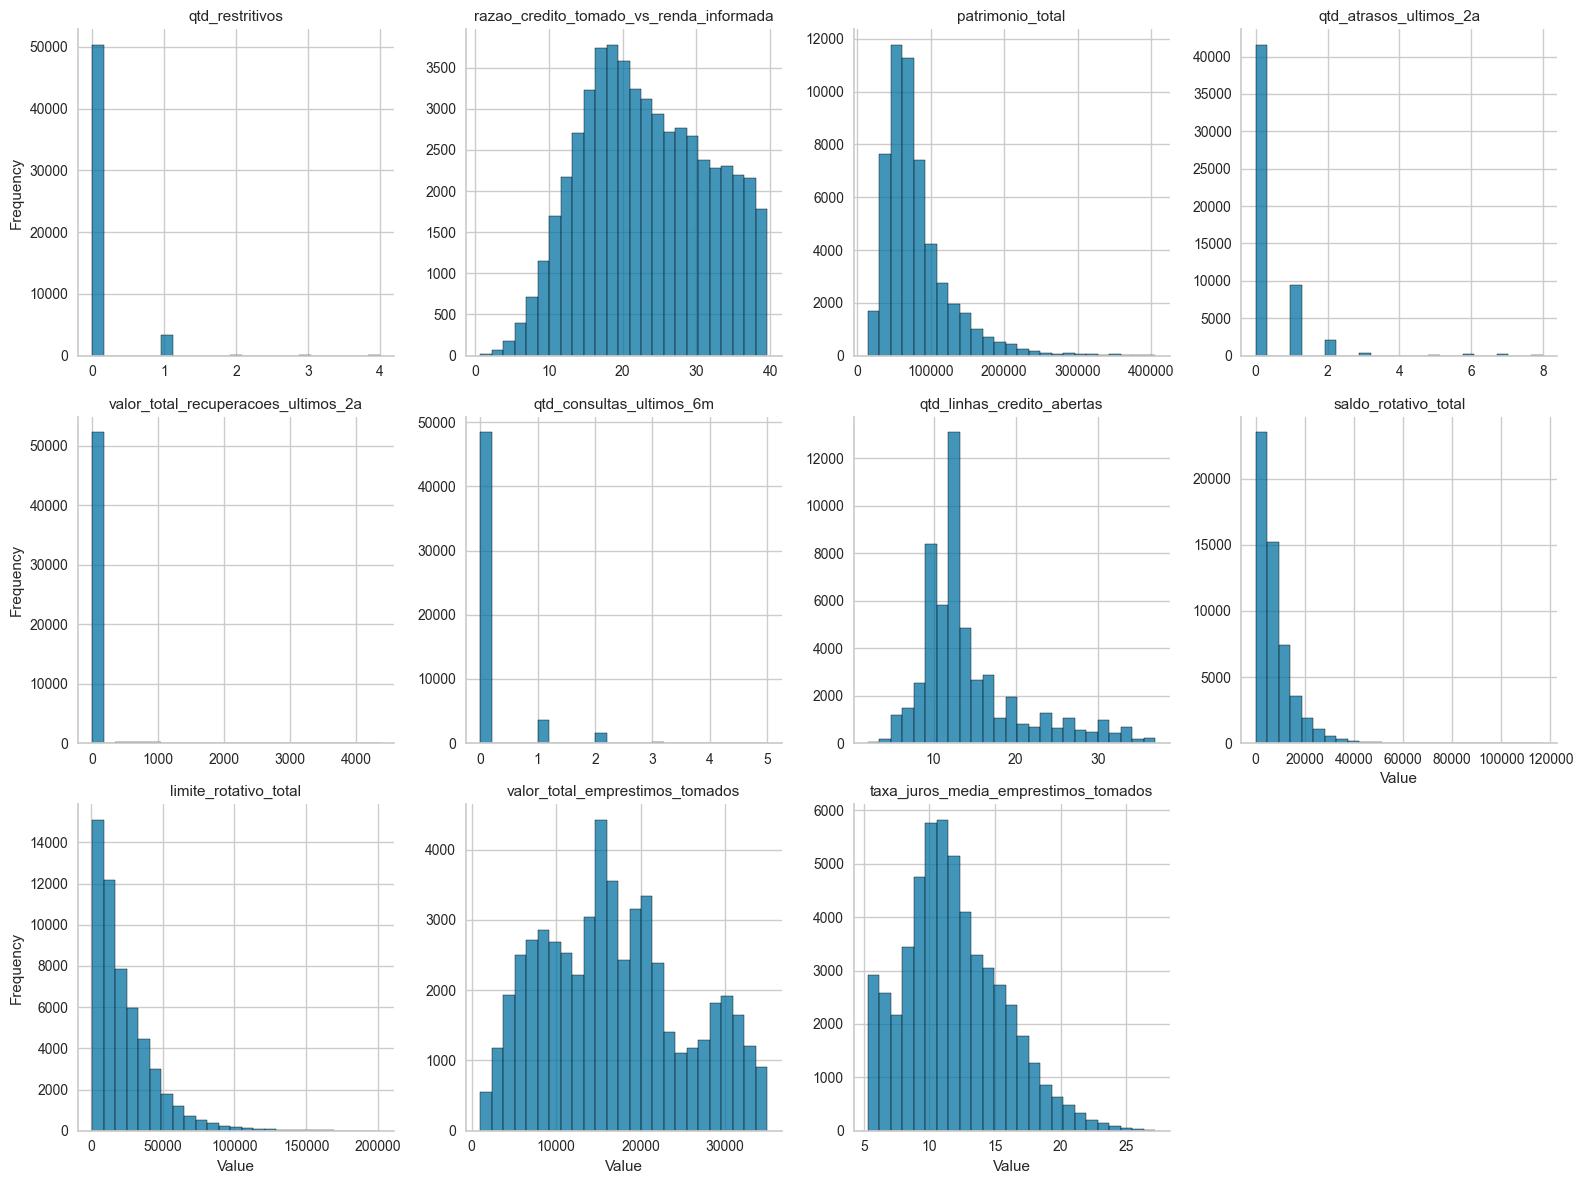

In [494]:
# Plotando distribuição das variáveis numéricas

melted_X_train = X_train_encoded[numerical_cols].melt(var_name = 'Column', value_name = 'Value')

# Criando facetgrid
g = sns.FacetGrid(melted_X_train, col = 'Column', col_wrap = 4,
                  sharex = False, sharey = False, height = 4)

# map histplot para cada faceta
g.map(sns.histplot, 'Value', bins = 25)

# adicionando títulos e labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template= '{col_name}')

plt.tight_layout()

ALguns modelos de machine learning são sensíveis à distribuição dos dados pois assumem normalidade ou se beneficiam dela, assim como Logistic regression que usaremos na nossa modelagem. Aqui vemos que algumas variáeis como patrimonio_total, saldo_rotativo_total e limite_rotativo_total apresentam uma assimetria à direita. Se a variável tiver uma calda muito longa, o ideal é aplicar logaritmo na mesma. Se as caldas não forem tão longas, um jeito comum de fazer a distribuição ficar simétrica é aplicar a raiz quadrada na mesma. Vamos prosseguir com a segunda opção.

In [495]:
# Definindo variáveis que receberão o tratamento para simetria
skewed_features = ['patrimonio_total', 'qtd_linhas_credito_abertas', 'saldo_rotativo_total', 'limite_rotativo_total', 'taxa_juros_media_emprestimos_tomados']

# Criando função que tira raiz quadrada
def sqrt_das_variaveis(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        data[feature] = np.sqrt(data[feature])
    return data

# Usando a função
X_train_cleaned_sqrt = sqrt_das_variaveis(X_train_encoded, skewed_features)

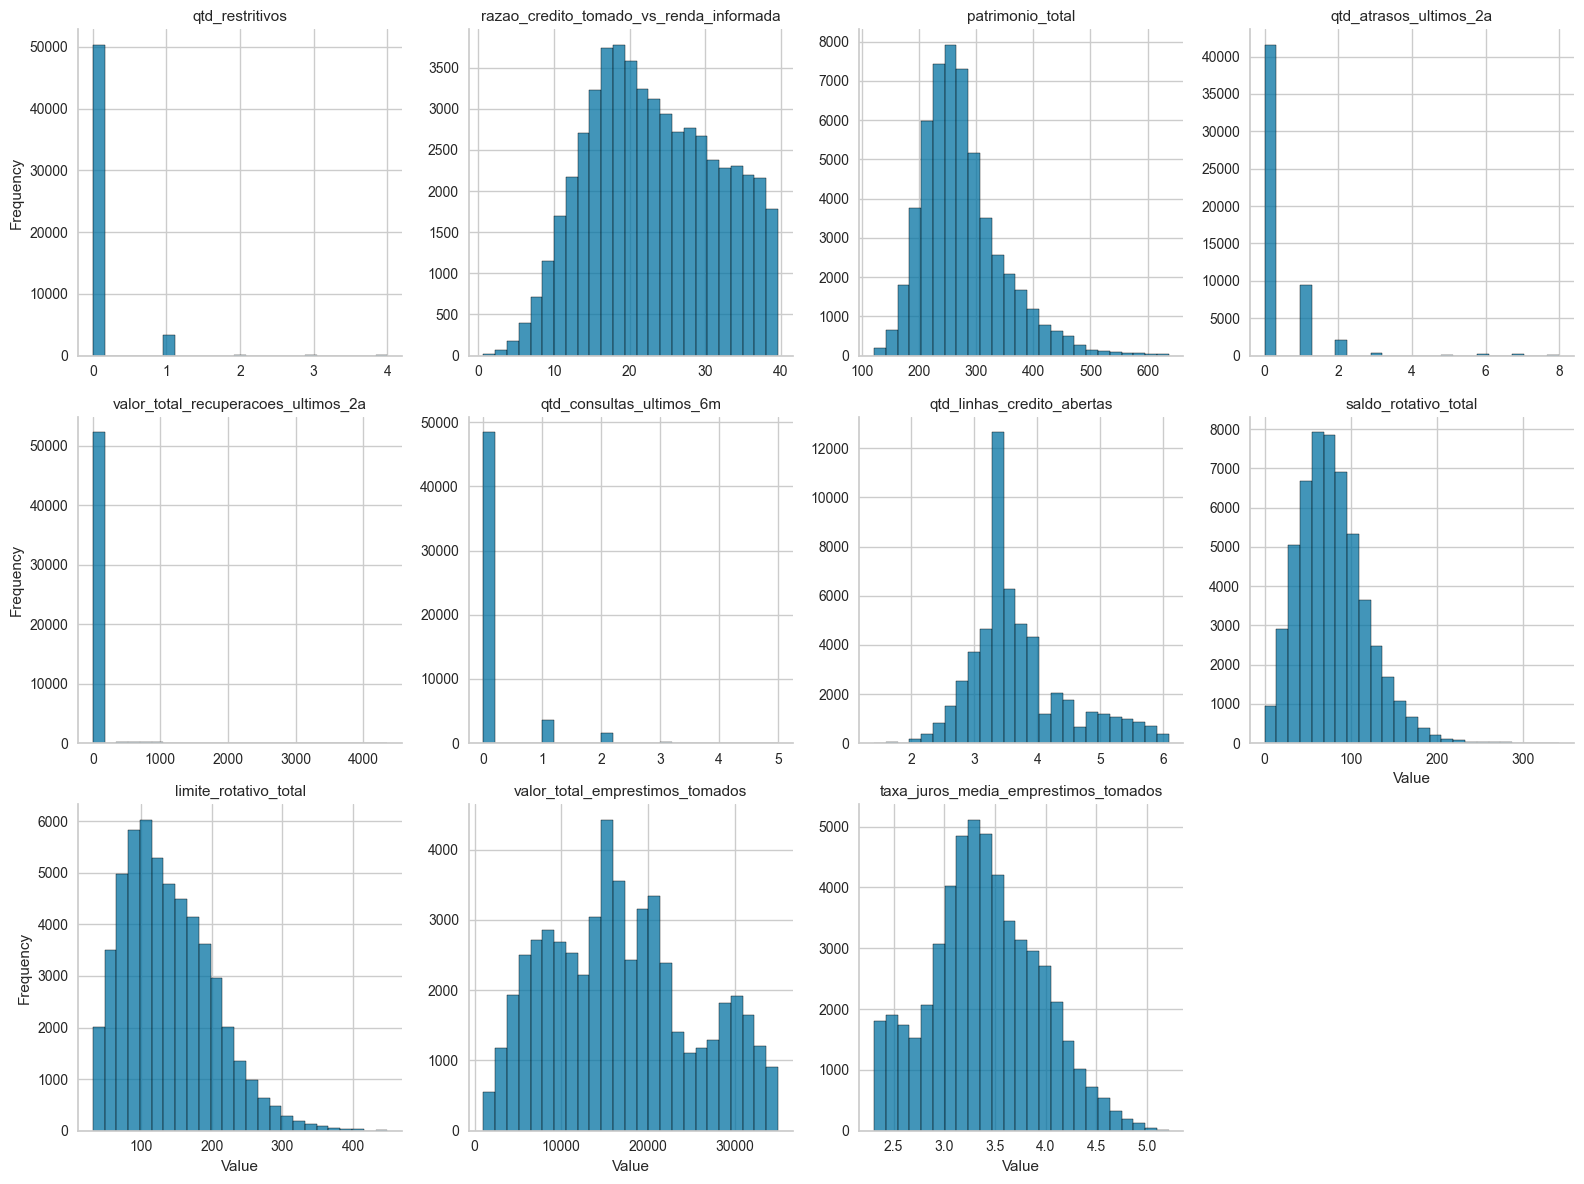

In [496]:
# Plotando distribuição das variáveis numéricas

melted_X_train = X_train_cleaned_sqrt[numerical_cols].melt(var_name = 'Column', value_name = 'Value')

# Criando facetgrid
g = sns.FacetGrid(melted_X_train, col = 'Column', col_wrap = 4,
                  sharex = False, sharey = False, height = 4)

# map histplot para cada faceta
g.map(sns.histplot, 'Value', bins = 25)

# adicionando títulos e labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template= '{col_name}')

plt.tight_layout()

vemos que não houve grande diferença na simetria com a aplicação da raiz quadrada, vamos refazer utilizando logaritmo.

In [497]:
# Criando função que aplica logaritmo
def log_das_variaveis(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        data[feature] = np.log1p(data[feature])
    return data

# Usando a função
X_train_cleaned_log = log_das_variaveis(X_train_encoded, skewed_features)

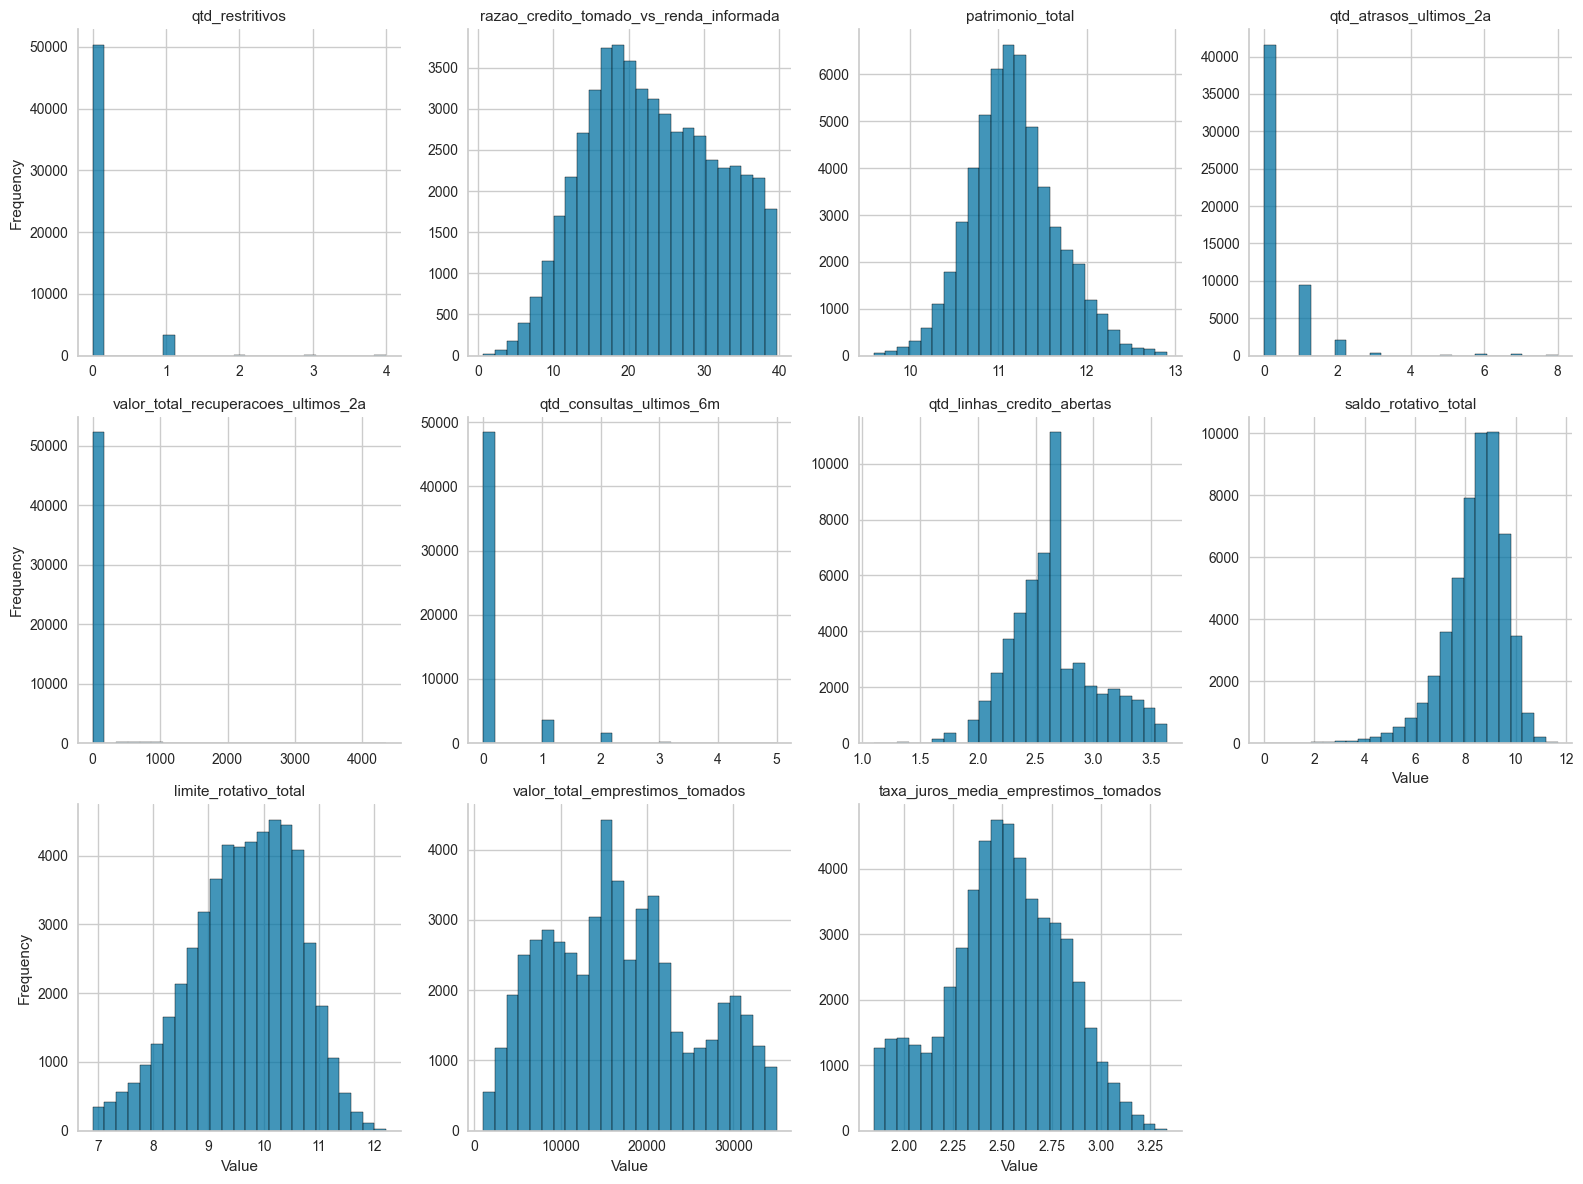

In [498]:
# Plotando distribuição das variáveis numéricas

melted_X_train = X_train_cleaned_log[numerical_cols].melt(var_name = 'Column', value_name = 'Value')

# Criando facetgrid
g = sns.FacetGrid(melted_X_train, col = 'Column', col_wrap = 4,
                  sharex = False, sharey = False, height = 4)

# map histplot para cada faceta
g.map(sns.histplot, 'Value', bins = 25)

# adicionando títulos e labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template= '{col_name}')

plt.tight_layout()

In [499]:
# Vamos checar a performance dos modelos antes e depois da transformação logaritma

lr_clf = LogisticRegression(solver = 'liblinear', max_iter = 2000)
ada_clf = AdaBoostClassifier(random_state= 42)
gb_clf = GradientBoostingClassifier(random_state= 42)

def check_performance(data_before, data_after, model):
    # Check performance with cross-validation
    cv_scores = cross_val_score(model, data_before, y_train, cv = kf, scoring='roc_auc')
    cv_scores_log = cross_val_score(model, data_after, y_train, cv = kf, scoring='roc_auc')

    print(f'CV score without transform : {cv_scores.mean()}')
    print(f'CV score with transform: {cv_scores_log.mean()}')
    return cv_scores, cv_scores_log

# Aplicando a função para verificar a performance antes e depois da transformação
print('Logistic Regression')
cv_scores_log_reg, cv_scores_log_reg_log = check_performance(X_train_encoded, X_train_cleaned_log, lr_clf)

print('AdaBoost')
cv_scores_ada, cv_scores_ada_log = check_performance(X_train_encoded, X_train_cleaned_log, ada_clf)

print('Gradient Boost')
cv_scores_gradboo, cv_scores_gradboo_log = check_performance(X_train_encoded, X_train_cleaned_log, gb_clf)


Logistic Regression
CV score without transform : 0.49902711438731984
CV score with transform: 0.6107234248247985
AdaBoost
CV score without transform : 0.6378633911114667
CV score with transform: 0.6378633911114667
Gradient Boost
CV score without transform : 0.6384611922236468
CV score with transform: 0.6384500626242946


Isso mostra que a transformação logística não teve impacto negativo nos modelos, e que para a regressão logística houve uma melhora considerável. 

Feature scaling

In [500]:
# Definindo a função que vai aplicar a standartização das variáveis
def scale_features(data_df, numeric_features):
    data = data_df.copy()
    #Inicializando o scaler
    scaler = StandardScaler()
    # Fit scaler
    scaler.fit(data[numeric_features])
    # Transformação das variáveis
    data[numeric_features] = scaler.transform(data[numeric_features])
    return data

# Aplicando a função
X_train_cleaned_log_scaled = scale_features(X_train_cleaned_log, numerical_cols)

In [501]:
# Aplicando a função para verificar a performance antes e depois da transformação de standartização
print('Logistic Regression')
cv_scores_log_reg_log, cv_scores_log_reg_log_scaled = check_performance( X_train_cleaned_log, X_train_cleaned_log_scaled, lr_clf)

print('AdaBoost')
cv_scores_ada_log, cv_scores_ada_log_scaled = check_performance( X_train_cleaned_log, X_train_cleaned_log_scaled, ada_clf)

print('Gradient Boost') 
cv_scores_gradboo_log, cv_scores_gradboo_log_scaled = check_performance( X_train_cleaned_log, X_train_cleaned_log_scaled,  gb_clf)

Logistic Regression
CV score without transform : 0.6107234248247985
CV score with transform: 0.6206530098835044
AdaBoost
CV score without transform : 0.6378633911114667
CV score with transform: 0.6378643183798559
Gradient Boost
CV score without transform : 0.6384500626242946
CV score with transform: 0.6384778018356154


Mais uma melhora no modelo de Regressão Logística após a padronização.

In [502]:
X_train_cleaned_final = X_train_cleaned_log_scaled.copy()

### 8. Model Pipeline

8.1 Customizando transformers


In [503]:
# Criando transformador para remover colunas desnecessárias
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return X.drop(columns = self.columns_to_drop)
    
    def get_feature_names_out(self, input_features = None):
        return None
    
    
# Criando transformador para aplicar o logaritmo nas variáveis
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X[self.columns_to_transform] = np.log1p(X[self.columns_to_transform])
        return X
    
    def get_feature_names_out(self, input_features = None):
        return input_features

8.2 Pipelines

In [504]:
# Colocando as saídas do tranformar como pandas dfs
set_config(transform_output= 'pandas')

colunas_para_deletar = ['client_id', 'contas_distintas_com_atraso']
# Definindo column dropper pipeline
cols_to_drop_pipeline = Pipeline([
    ('col_dropper', ColumnDropper(colunas_para_deletar))
])

# Definindo variáveis para melhorar assimetria
skewed_features = ['patrimonio_total', 'qtd_linhas_credito_abertas', 'saldo_rotativo_total', 'limite_rotativo_total', 'taxa_juros_media_emprestimos_tomados']

# Definindo variáveis numéricas pipeline
num_pipeline = Pipeline([
    ('log', LogTransformer(skewed_features)),
    ('scaler', StandardScaler())
])

# Definindo rank das variávies categóricas ordinais
grade_ordem = sorted(credito_df['grade'].dropna().unique())
sub_grade_ordem = sorted(credito_df['sub_grade'].dropna().unique())

# Definindo pipeline das variáveis categoricas ordinais
cat_ord_pipeline = Pipeline([
    ('ord_encoder', OrdinalEncoder(categories= [grade_ordem, sub_grade_ordem]))
])

# Definindo pipeline das variáveis binárias categóricas
cat_bin_pipeline = Pipeline([
    ('binary_encoder', OrdinalEncoder())
])

# Definindo pipeline das variáveis categoricas one-hot
cat_one_hot_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(handle_unknown= 'ignore', sparse_output= False, drop = 'first'))
])

# Definindo pipeline de pré processamento  com column transformer
preprocess_pipeline = ColumnTransformer([
    ('drop_features', cols_to_drop_pipeline, colunas_para_deletar),
    ('num', num_pipeline, numerical_cols),
    ('cat_ord', cat_ord_pipeline, cat_cols_ord),
    ('cat_bin', cat_bin_pipeline, cat_cols_bin),
    ('cat_one_hot', cat_one_hot_pipeline, cat_cols_one_hot)
])

In [505]:
# Vamos ver se o df que criamos com o pipeline é o mesmo que criamos manualmente com as transformações
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

In [ ]:
# Create a df from the processed data
X_train_prepared_df = pd.DataFrame(
    X_train_prepared,
    columns = preprocess_pipeline.get_feature_names_out()
)

# Get names of the new one-hot columns
oh_encoder = preprocess_pipeline.transformers_[4][1].named_steps['one_hot_encoder']
one_hot_col_names = list(oh_encoder.get_feature_names_out(cat_cols_one_hot))

# Create list of all column names
new_col_names = numerical_cols + cat_cols_ord + cat_cols_bin + one_hot_col_names

# Reset df columns
X_train_prepared_df.columns = new_col_names

# Reset index
X_train_prepared_df.reset_index( drop= True, inplace = True)

# Inpect of
X_train_prepared_df.head()

qtd_restritivos  razao_credito_tomado_vs_renda_informada  patrimonio_total  \
0        -0.233174                                -1.409492          0.701383   
1        -0.233174                                 1.851615         -1.155109   
2        -0.233174                                 0.898881         -0.695890   
3        -0.233174                                 0.576143         -0.316111   
4        -0.233174                                 0.302674          1.870837   

   qtd_atrasos_ultimos_2a  valor_total_recuperacoes_ultimos_2a  \
0               -0.409178                            -0.165407   
1               -0.409178                            -0.148896   
2               -0.409178                            -0.163475   
3                0.836779                            -0.165789   
4                2.082735                            -0.151110   

   qtd_consultas_ultimos_6m  qtd_linhas_credito_abertas  saldo_rotativo_total  \
0                 -0.306776                    0.141241             -0.014507   
1                 -0.306776                   -1.584138             -1.505519   
2                 -0.306776                   -0.251536              0.678320   
3                 -0.306776                    0.141241             -0.539940   
4                 -0.306776                    2.220905              0.965620   

   limite_rotativo_total  valor_total_emprestimos_tomados  \
0               0.201747                        -0.040440   
1              -0.115094                        -0.143879   
2               0.875082                         1.224979   
3               0.524423                         0.691881   
4               0.314627                        -0.163490   

   taxa_juros_media_emprestimos_tomados  grade  sub_grade  pf_ou_pj  \
0                             -0.085852    3.0       20.0       0.0   
1                              1.020820    2.0       14.0       0.0   
2                             -0.345108    0.0        3.0       0.0   
3                              0.794213    1.0       19.0       0.0   
4                              1.453540    3.0        8.0       0.0   

   verificacao_fonte_de_renda_Source Verified  \
0                                         1.0   
1                                         0.0   
2                                         1.0   
3                                         1.0   
4                                         0.0   

   verificacao_fonte_de_renda_Verified  
0                                  0.0  
1                                  0.0  
2                                  0.0  
3                                  0.0  
4                                  0.0

In [507]:
X_train_cleaned_final.head()

qtd_restritivos  razao_credito_tomado_vs_renda_informada  \
12727        -0.233174                                -1.409492   
466          -0.233174                                 1.851615   
49785        -0.233174                                 0.898881   
32791        -0.233174                                 0.576143   
795          -0.233174                                 0.302674   

       patrimonio_total  qtd_atrasos_ultimos_2a  \
12727          0.701383               -0.409178   
466           -1.155109               -0.409178   
49785         -0.695890               -0.409178   
32791         -0.316111                0.836779   
795            1.870837                2.082735   

       valor_total_recuperacoes_ultimos_2a  qtd_consultas_ultimos_6m  \
12727                            -0.165407                 -0.306776   
466                              -0.148896                 -0.306776   
49785                            -0.163475                 -0.306776   
32791                            -0.165789                 -0.306776   
795                              -0.151110                 -0.306776   

       qtd_linhas_credito_abertas  saldo_rotativo_total  \
12727                    0.141241             -0.014507   
466                     -1.584138             -1.505519   
49785                   -0.251536              0.678320   
32791                    0.141241             -0.539940   
795                      2.220905              0.965620   

       limite_rotativo_total  valor_total_emprestimos_tomados  \
12727               0.201747                        -0.040440   
466                -0.115094                        -0.143879   
49785               0.875082                         1.224979   
32791               0.524423                         0.691881   
795                 0.314627                        -0.163490   

       taxa_juros_media_emprestimos_tomados  grade  sub_grade  pf_ou_pj  \
12727                             -0.085852    3.0       20.0       0.0   
466                                1.020820    2.0       14.0       0.0   
49785                             -0.345108    0.0        3.0       0.0   
32791                              0.794213    1.0       19.0       0.0   
795                                1.453540    3.0        8.0       0.0   

       verificacao_fonte_de_renda_Source Verified  \
12727                                         1.0   
466                                           0.0   
49785                                         1.0   
32791                                         1.0   
795                                           0.0   

       verificacao_fonte_de_renda_Verified  
12727                                  0.0  
466                                    0.0  
49785                                  0.0  
32791                                  0.0  
795                                    0.0

In [508]:
X_train_cleaned_final.reset_index(drop= True).equals(X_train_prepared_df)

True

#### 9. Otimização dos hiperparâmetros


In [509]:
# Criando random search com roc_auc como métrica
scorer = make_scorer(roc_auc_score, needs_proba = True)

def quick_test(model,  grid):
    quick_test = RandomizedSearchCV(
        estimator=model,
        param_distributions=grid,
        n_iter=5,  # Teste leve
        scoring='roc_auc',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1,
        error_score='raise'  # Força a mostrar o erro logo
    )

    quick_test.fit(X_train_prepared_df, y_train)
    return quick_test


def random_search_model(model, model_name, grid):
    random_search = RandomizedSearchCV(
        estimator = model,
        param_distributions= grid,
        n_iter = 400,
        scoring = 'roc_auc',
        cv = 3,
        verbose = 1, 
        random_state= 42,
        n_jobs = -1,
        error_score = 'raise'
    )

    random_search.fit(X_train_prepared_df, y_train)

    # Imprimindo os melhores parametros e score
    print(f'Model : {model_name}')
    print(f'best parameters found: {random_search.best_params_}')
    print(f'best cross-validation score: {random_search.best_score_}')

    model_name_clean = model_name.replace(" ", "_")

    joblib.dump(random_search.best_estimator_, model_name_clean +'.pkl')
    return random_search
    

def grid_search_model(model, model_name, grid):
    grid_search = GridSearchCV(
        estimator = model, 
        param_grid = grid,
        scoring = 'roc_auc',
        cv = 5,
        verbose = 1,
        n_jobs = -1
    )

    # Fit o modelo do grid search
    grid_search.fit(X_train_prepared_df, y_train)

    # Imprimindo resultados
    print(f'Model : {model_name}')
    print(f'Best parameters found: {grid_search.best_params_}')
    print(f'Best cross-validation score: {grid_search.best_score_}')

    return grid_search


9.1 Logistic Regression

In [365]:
log_reg_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': uniform(0.01, 10),
    'solver': ['liblinear', 'saga'],  # removi lbfgs que não suporta l1
    'max_iter': randint(100, 1000)
}

In [366]:
# Inicializando o Classificador
log_reg_model = LogisticRegression(random_state=42)



In [348]:
quick_teste_log_reg = quick_test(log_reg_model, "Logistic Regression", log_reg_param_grid)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [367]:
log_random_search = random_search_model(log_reg_model, "Logistic Regression", log_reg_param_grid)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
Model : Logistic Regression
best parameters found: {'C': np.float64(0.08066305219717405), 'max_iter': 956, 'penalty': 'l1', 'solver': 'liblinear'}
best cross-validation score: 0.6211402929469779


In [373]:
# Definindo o novo grid expandido de acordo com o random search
log_reg_param_grid_grid_search = {
    'penalty' : ['l1'],
    'C' : [0.07, 0.08, 0.09, 0.1],
    'solver' : ['liblinear'],
    'max_iter' : [945,950,955,1000]
}



In [ ]:

grid_results_log_reg = grid_search_model(log_reg_model, "Logistic Regression", log_reg_param_grid_grid_search)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Model : Logistic Regression
Best parameters found: {'C': 0.07, 'max_iter': 945, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.6209461616708265


In [380]:
joblib.dump(grid_results_log_reg.best_estimator_, 'Logistic_Regression_best.pkl')

['Logistic_Regression_best.pkl']

9.2 Ada Boost

In [357]:
ada_param_grid = {
    'n_estimators' : randint(50, 300),
    'learning_rate' : uniform(0.01, 1.0),
    'algorithm': ['SAMME']
}

In [ ]:
ada_model = AdaBoostClassifier(random_state= 42)


In [358]:
quick_teste_ada = quick_test(ada_model, "Ada Boost", ada_param_grid)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.



In [368]:
ada_random_search = random_search_model(ada_model, "AdaBoost", ada_param_grid)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.



Model : AdaBoost
best parameters found: {'algorithm': 'SAMME', 'learning_rate': np.float64(0.3826868670940493), 'n_estimators': 283}
best cross-validation score: 0.6400837424571136


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=AdaBoostClassifier(random_state=42), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['SAMME'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000021CF807DD00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000021CF804A540>},
                   random_state=42, scoring='roc_auc', verbose=1)

In [376]:
# Definindo o grid de parametros novamente
ada_param_grid_grid_search = {
    'n_estimators' : [277, 280, 283, 286],
    'learning_rate' : [0.35, 0.4, 0.45, 0.5],
    'algorithm': ['SAMME']
}

In [377]:
grid_results_ada = grid_search_model(ada_model, "AdaBoost", ada_param_grid_grid_search)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.



Model : AdaBoost
Best parameters found: {'algorithm': 'SAMME', 'learning_rate': 0.45, 'n_estimators': 277}
Best cross-validation score: 0.6390207646452364


In [381]:
joblib.dump(grid_results_ada.best_estimator_, 'AdaBoost_best.pkl')

['AdaBoost_best.pkl']

9.3 Gradient Boosting

In [369]:
gradboost_param_grid = {
    'n_estimators' : randint(50,300),
    'learning_rate' : uniform(0.01,0.3),
    'max_depth' : randint(1,10),
    'subsample' : uniform(loc=0.1, scale=0.9),
    'min_samples_split' : randint(2,20),
    'min_samples_leaf': randint(1,20)

}

In [ ]:
gradboost_model = GradientBoostingClassifier(random_state = 42)


In [363]:
quick_teste_ada = quick_test(gradboost_model, "Gradient Boosting", gradboost_param_grid)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [371]:
gradboo_random_search = random_search_model(gradboost_model, "GradientBoost", gradboost_param_grid)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
Model : GradientBoost
best parameters found: {'learning_rate': np.float64(0.03182890190925806), 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 78, 'subsample': np.float64(0.17635394267667273)}
best cross-validation score: 0.6412961944500737


In [378]:
gradboost_param_grid_grid_search = {
    'n_estimators' : [75, 78, 80, 85],
    'learning_rate' : [0.025, 0.03, 0.035, 0.04],
    'max_depth' : [1,2,3],
    'subsample' : [0.15, 0.16, 0.17, 0.18],
    'min_samples_split' : [4,6,8],
    'min_samples_leaf': [2,3,4]

}

In [379]:
grid_results_gradboo = grid_search_model(gradboost_model, "Gradient Boosting", gradboost_param_grid_grid_search)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Model : Gradient Boosting
Best parameters found: {'learning_rate': 0.025, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 78, 'subsample': 0.16}
Best cross-validation score: 0.641309284306716


In [382]:
joblib.dump(grid_results_gradboo.best_estimator_, 'GradientBoosting_best.pkl')

['GradientBoosting_best.pkl']

Comparando os resultados dos modelos com hyperparameters tuned e default

In [383]:

cv_scores_log_reg_antes = cross_val_score(log_reg_model, X_train_prepared_df, y_train, cv = kf, scoring='roc_auc')
cv_scores_ada_antes = cross_val_score(ada_model, X_train_prepared_df, y_train, cv = kf, scoring='roc_auc')
cv_scores_gradBoo_antes = cross_val_score(gradboost_model, X_train_prepared_df, y_train, cv = kf, scoring='roc_auc')




In [384]:
print("Logistic Regression")
print(f'CV Score com hiperparâmetros default: {cv_scores_log_reg_antes.mean()} ')
print(f'CV Score com tuned hiperparâmetros: {grid_results_log_reg.best_score_}')

print("Ada Boost")
print(f'CV Score com hiperparâmetros default: {cv_scores_ada_antes.mean()} ')
print(f'CV Score com tuned hiperparâmetros: {grid_results_ada.best_score_}')

print("Gradient Boost")
print(f'CV Score com hiperparâmetros default: {cv_scores_gradBoo_antes.mean()} ')
print(f'CV Score com tuned hiperparâmetros: {grid_results_gradboo.best_score_}')

Logistic Regression
CV Score com hiperparâmetros default: 0.6206928158208681 
CV Score com tuned hiperparâmetros: 0.6209461616708265
Ada Boost
CV Score com hiperparâmetros default: 0.6378643183798559 
CV Score com tuned hiperparâmetros: 0.6390207646452364
Gradient Boost
CV Score com hiperparâmetros default: 0.6384778018356154 
CV Score com tuned hiperparâmetros: 0.641309284306716


Os scores deram uma melhorada, mas ainda é possível tentar melhorar os hiperparâmetros, fazer transformações adicionais e retirar algumas variáveis. Outra sugestão seria utilizar outros algoritmos e verificar se possuem um melhor desempenho, porém devido a limitações computacionais e tempo disponível, priorizei a otimização e validação produnda dos três modelos que são promissores e já conhecidos por sua eficácia em problemas de classificação tubular:
- Logistic Regression
- AdaBoost
- Gradient Boosting

Nesse ponto já podemos fazer previsões com os nossos dados de teste.

### 10. Avaliação dos modelos

In [510]:
# Importando os modelos caso precise
log_model_best = joblib.load('Logistic_Regression_best.pkl')
ada_model_best = joblib.load('AdaBoost_best.pkl')
gradboost_model_best = joblib.load('GradientBoosting_best.pkl')

10.1 Aplicando os modelos nos dados e teste

In [518]:
# Preparando os dados de teste usando o pipeline
preprocess_pipeline.fit(X_train)
X_test_prepared = preprocess_pipeline.transform(X_test)

# Cria o DataFrame igual ao do treino
X_test_prepared_df = pd.DataFrame(
    X_test_prepared,
    columns = preprocess_pipeline.get_feature_names_out()
)

# Altera os nomes das colunas como fez no treino
oh_encoder = preprocess_pipeline.transformers_[4][1].named_steps['one_hot_encoder']
one_hot_col_names = list(oh_encoder.get_feature_names_out(cat_cols_one_hot))
new_col_names = numerical_cols + cat_cols_ord + cat_cols_bin + one_hot_col_names
X_test_prepared_df.columns = new_col_names

# Reseta índice (opcional, mas para garantir consistência)
X_test_prepared_df.reset_index(drop=True, inplace=True)

c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning:

This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.



In [519]:
# Prevendo valores de y_test usando as melhores versões dos modelos criado pelo grid search
y_pred_log_reg = log_model_best.predict(X_test_prepared_df)
y_pred_ada = ada_model_best.predict(X_test_prepared_df)
y_gradBoo = gradboost_model_best.predict(X_test_prepared_df)

In [520]:
# Probabilidades
y_prob_log = log_model_best.predict_proba(X_test_prepared_df)[:,1]
y_prob_ada = ada_model_best.predict_proba(X_test_prepared_df)[:,1]
y_prob_grad = gradboost_model_best.predict_proba(X_test_prepared_df)[:,1]

In [ ]:

def confusion_matrix_plot(y_test,y_pred, model, model_name):
    # Gera a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)

    # Plota
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="Blues")  # Pode mudar o colormap se quiser
    plt.title("Matriz de Confusão - " + model_name)
    plt.show()


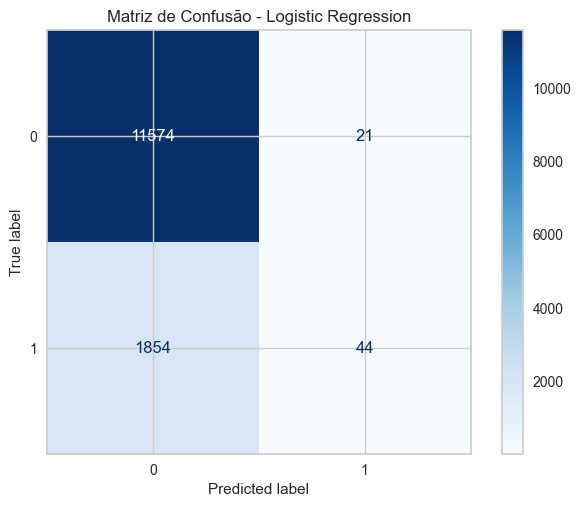

In [523]:
confusion_matrix_plot(y_test, y_pred_log_reg, log_model_best, 'Logistic Regression')

In [524]:
print(classification_report(y_test, y_pred_log_reg))
print("ROC AUC:", roc_auc_score(y_test, y_prob_log))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93     11595
           1       0.68      0.02      0.04      1898

    accuracy                           0.86     13493
   macro avg       0.77      0.51      0.48     13493
weighted avg       0.84      0.86      0.80     13493

ROC AUC: 0.6235021454234979


A Regressão Logística apresentou boa performance na identificação de clientes adimplentes (classe 0), com uma acurácia geral de 86% e um recall de 1.00 para essa classe. No entanto, o modelo teve dificuldade significativa em identificar corretamente os inadimplentes (classe 1), apresentando um recall de apenas 0.02 e um F1-score de 0.04 para essa classe. Esse desempenho indica que o modelo está fortemente inclinado a prever a classe majoritária, falhando em capturar os padrões associados à inadimplência. O valor do ROC AUC, de 0.62, confirma essa limitação, pois embora seja superior ao acaso (0.5), ainda é considerado baixo para tarefas de classificação binária com foco em identificação de riscos. Esses resultados sugerem a necessidade de estratégias adicionais, como balanceamento das classes ou ajuste do limiar de decisão, para melhorar a sensibilidade do modelo em relação aos casos de inadimplência.

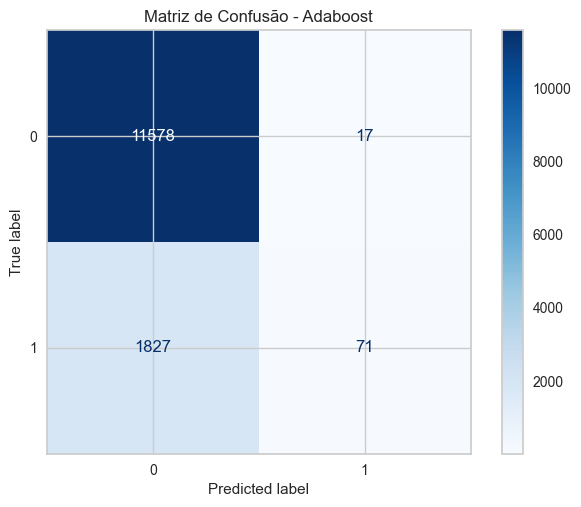

In [531]:
confusion_matrix_plot(y_test, y_pred_ada, ada_model_best, 'Adaboost')

In [ ]:
print(classification_report(y_test, y_pred_ada))
print("ROC AUC:", roc_auc_score(y_test, y_prob_ada))



              precision    recall  f1-score   support

           0       0.86      1.00      0.93     11595
           1       0.81      0.04      0.07      1898

    accuracy                           0.86     13493
   macro avg       0.84      0.52      0.50     13493
weighted avg       0.86      0.86      0.81     13493

ROC AUC: 0.641710867888897


O modelo AdaBoost obteve desempenho semelhante ao da Regressão Logística em termos de acurácia geral (86%), porém com leve melhora na identificação da classe minoritária (inadimplentes). O recall da classe 1 subiu para 0.04, e o F1-score foi de 0.07, ainda considerados baixos, mas superiores aos da Regressão Logística. Isso indica que o modelo foi um pouco mais eficaz em capturar os padrões associados à inadimplência, mesmo que de forma ainda limitada. O valor de ROC AUC de 0.64 reforça esse resultado, mostrando uma pequena melhora na capacidade discriminativa do modelo em relação ao baseline aleatório. Apesar da baixa sensibilidade, o AdaBoost demonstrou maior equilíbrio entre precisão e recall para a classe 1, sendo uma alternativa levemente superior no contexto atual. Estratégias como balanceamento de classes ou ajuste do threshold de decisão podem ser úteis para explorar melhor o potencial desse modelo

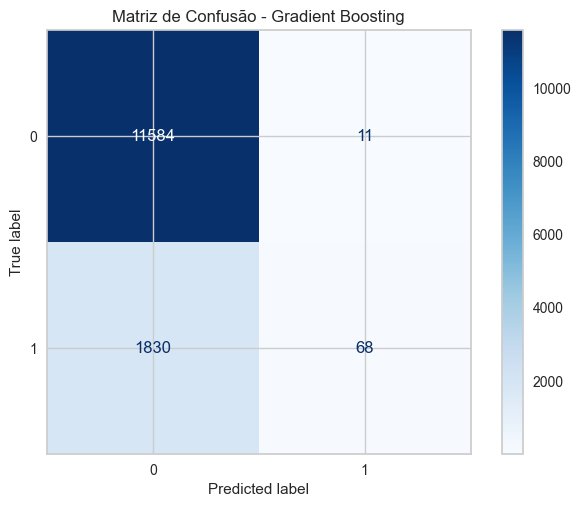

In [527]:
confusion_matrix_plot(y_test, y_gradBoo, gradboost_model_best, 'Gradient Boosting')

In [528]:

print(classification_report(y_test, y_gradBoo))
print("ROC AUC:", roc_auc_score(y_test, y_prob_grad))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93     11595
           1       0.86      0.04      0.07      1898

    accuracy                           0.86     13493
   macro avg       0.86      0.52      0.50     13493
weighted avg       0.86      0.86      0.81     13493

ROC AUC: 0.6400209975685353


O modelo Gradient Boosting apresentou desempenho global semelhante aos demais modelos testados, com acurácia de 86%. Assim como o AdaBoost, demonstrou uma ligeira melhoria na identificação de inadimplentes (classe 1), alcançando um recall de 0.04 e F1-score de 0.07. A precisão para essa classe foi de 0.86, o que indica que, embora poucos inadimplentes tenham sido corretamente identificados, quando o modelo os previu, acertou em grande parte dos casos. O valor de ROC AUC foi 0.64, próximo ao do AdaBoost, indicando uma capacidade discriminativa um pouco melhor que a Regressão Logística. Apesar disso, o modelo ainda enfrenta dificuldades em capturar padrões da classe minoritária, e ajustes futuros podem incluir estratégias como reamostragem dos dados ou uso de métricas ponderadas na otimização do modelo.

10.3 Curva ROC auc

<Figure size 800x600 with 0 Axes>

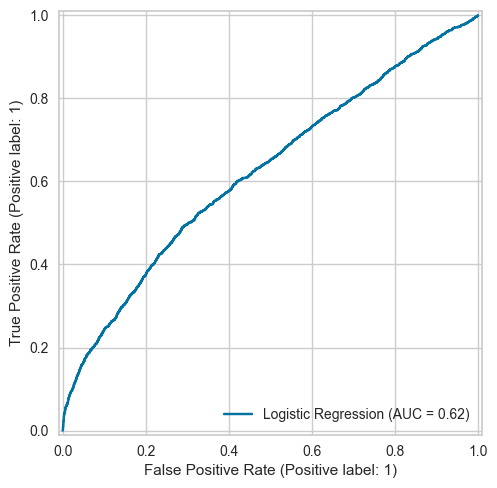

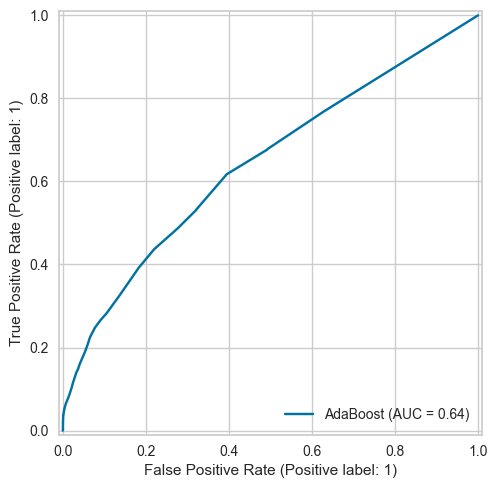

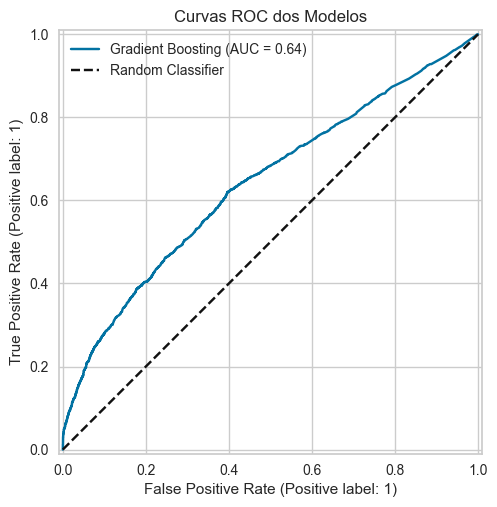

In [ ]:


plt.figure(figsize=(8,6))

RocCurveDisplay.from_predictions(y_test, y_prob_log, name="Logistic Regression")
RocCurveDisplay.from_predictions(y_test, y_prob_ada, name="AdaBoost")
RocCurveDisplay.from_predictions(y_test, y_prob_grad, name="Gradient Boosting")

plt.plot([0,1],[0,1], 'k--', label='Random Classifier')
plt.legend()
plt.title("Curvas ROC dos Modelos")
plt.show()


10.4 Tentativa de melhora do modelo


10.4.1 Seleção de variáveis com SelectKBest

In [ ]:


# Aplicando o SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)  # Seleciona as 10 melhores features
X_train_kbest = selector.fit_transform(X_train_prepared_df, y_train)

# Para saber quais variáveis foram selecionadas:
selected_mask = selector.get_support()
selected_features = X_train_prepared_df.columns[selected_mask]
print("Variáveis selecionadas:", selected_features)


Variáveis selecionadas: Index(['qtd_restritivos', 'razao_credito_tomado_vs_renda_informada',
       'patrimonio_total', 'qtd_atrasos_ultimos_2a',
       'qtd_consultas_ultimos_6m', 'qtd_linhas_credito_abertas',
       'saldo_rotativo_total', 'valor_total_emprestimos_tomados', 'grade',
       'verificacao_fonte_de_renda_Source Verified'],
      dtype='object')


In [537]:
X_train_prepared_df_selected = X_train_prepared_df[selected_features]
X_train_prepared_df_selected.head()

qtd_restritivos  razao_credito_tomado_vs_renda_informada  patrimonio_total  \
0        -0.233174                                -1.409492          0.701383   
1        -0.233174                                 1.851615         -1.155109   
2        -0.233174                                 0.898881         -0.695890   
3        -0.233174                                 0.576143         -0.316111   
4        -0.233174                                 0.302674          1.870837   

   qtd_atrasos_ultimos_2a  qtd_consultas_ultimos_6m  \
0               -0.409178                 -0.306776   
1               -0.409178                 -0.306776   
2               -0.409178                 -0.306776   
3                0.836779                 -0.306776   
4                2.082735                 -0.306776   

   qtd_linhas_credito_abertas  saldo_rotativo_total  \
0                    0.141241             -0.014507   
1                   -1.584138             -1.505519   
2                   -0.251536              0.678320   
3                    0.141241             -0.539940   
4                    2.220905              0.965620   

   valor_total_emprestimos_tomados  grade  \
0                        -0.040440    3.0   
1                        -0.143879    2.0   
2                         1.224979    0.0   
3                         0.691881    1.0   
4                        -0.163490    3.0   

   verificacao_fonte_de_renda_Source Verified  
0                                         1.0  
1                                         0.0  
2                                         1.0  
3                                         1.0  
4                                         0.0

In [ ]:
# Regressão Logistica
lr_clf = LogisticRegression(solver = 'liblinear', max_iter = 2000, class_weight= 'balanced')


cv_scores_log_weight = cross_val_score(lr_clf, X_train_prepared_df, y_train, cv = kf, scoring='roc_auc')
print(f'CV Score com hiperparâmetros default : {cv_scores_log_weight.mean()} ')
# 0.6235021454234979
# 0.6225964447673331 selecionando variáveis e aplicando peso



CV Score com hiperparâmetros default : 0.6220490337721277 


In [542]:
# Ada Boost
ada_clf = AdaBoostClassifier(
    estimator= DecisionTreeClassifier(class_weight='balanced'),
    random_state= 42)

cv_scores_ada_weight = cross_val_score(ada_clf, X_train_prepared_df, y_train, cv = kf, scoring='roc_auc')
print(f'CV Score com hiperparâmetros default: {cv_scores_ada_weight.mean()} ')
# 0.641710867888897
# 0.5227022889854624 selecionando variáveis e aplicando peso

CV Score com hiperparâmetros default: 0.5272488625231 


In [ ]:
# Gradient Boost não apresenta opção de usar class_weight
gb_clf = GradientBoostingClassifier(random_state= 42)

### 11.Conclusão e considerações finais

Conclusão:
Os três modelos avaliados — Regressão Logística, AdaBoost e Gradient Boosting — apresentaram desempenho semelhante em termos de acurácia (86%), refletindo uma boa capacidade de identificar corretamente os clientes adimplentes (classe majoritária). No entanto, todos enfrentaram dificuldades significativas na identificação dos inadimplentes (classe 1), como demonstrado pelos baixos valores de recall (entre 0.02 e 0.04) e F1-score (entre 0.04 e 0.07) para essa classe. O Gradient Boosting obteve o melhor resultado em termos de ROC AUC (0.64), seguido de perto pelo AdaBoost (0.6417) e pela Regressão Logística (0.6235), sugerindo que os métodos de boosting possuem uma capacidade um pouco superior de discriminar entre as classes.

Desta forma percebemos que os modelos ainda tem muito o que melhorar porque o principal objetivo que era identificar a inadimplência não foi comprida. Várias estratégias podem ser implementadas aqui na tentativa de aprimorar os modelos:
 - Aplicar técnicas de reamostragem:
    - SMOTE (Synthetic Minority Over-sampling Technique)
    - Undersampling da classe majoritária
 - Aplicar class_weight
 - Usar métodos mais robustos para seleção de variáveis
    - SelectKBest(f_classif)
    - model.feature_importances
    - RFE (Recursive Feature Elimination)
 - Dedicar mais tempo e mais iterações ao tuning dos hiperparâmetros
 - Implementar threshold tuning
 - Selecionar novos modelos com métricas diferentes (f1-score ou recall) 

Foi testado seleção de variáveis com SelectKBest e aplicação de pesos com class_weight para Logistic Regression e AdaBoost, mas ambos tiveram uma performance inferior ao modelo final apresentando. Usar todas as variáveis sem seleção pode ter contribuído para overfitting ou subaproveitamento.

Outra melhoria que vejo que pode ser feita aqui é no código. Mesmo usando o Pipeline eu vi que fiz alterações posteriores nos dados, então eu incluiria essas alterações dentro do Pipeline. Também seria de bom tom testar modelos robustos a desbalanceamento, como XGBoost com scale_pos_weight ajustado ou modelos de classificação com penalização de custo;

Estas ações podem melhorar significativamente a performance do modelo em identificar clientes inadimplentes, o que é essencial para a aplicação prática deste desafio.
